In [84]:
import numpy as np
import pandas as pd
import time
import datetime
import calendar
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score, accuracy_score
import re
import matplotlib.pyplot as plt
import seaborn as sns
import keras_tuner as kt
import imblearn
from collections import Counter
import plotly.graph_objects as go
from sklearn import impute
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import roc_curve
from prettytable import PrettyTable
# settings to display all columns
pd.set_option("display.max_columns", None)

import warnings
warnings.filterwarnings('ignore')
warnings.warn('-')
warnings.warn('-')

### Why it is more difficult to find a good classifier on such a dataset than on one where

Most deep learning algorithms will perform poorly and require modification to avoid simply predicting the majority class in all cases. Imbalanced data set like the current one has severely skewed class distribution which dramatically impact the ability to gain a large enough or representative sample of examples from the minority class. The algorithm bulit on such data set defines the class boundary in favor of the majority class at the expense of the minority class, treating the minority as nose. Classifiers therefore tend to ignore small classes while concentrating on classifying the large ones accurately. Additionally, metrics like classification lose their meaning and alternate methods for evaluating predictions on imbalanced examples are required, like ROC area under curve, which make the classification tast even more challenging

### What happens when undetected fraudulent claims are very costly to the insurance company.

In situation when undetected fraudulent claims are very costly to the insurance company, if the company could not build a good classifier, provided that they have a unbalanced dataset. Their model tend to misclassify (true positive rate is very low) most of the fraudulent cases as nonfraudulent, and therefore loss a huge amount of the moneny.

### Load the dataset "Insurance_claims.csv" and clean it as appropriate for use with machine learning algorithms.

Before actually processing Data, we first observe the existing columns according to the original dataset and classify them as the following. We first roughly classify the things and items that need to be processed for each feature:

Binary Features: Fraud, PolicyWasSubscribedOnInternet, ClaimWihoutIdentifiedThirdParty, and LossAndHolderPostCodeSame

Get dummies Features: PolicyholderOccupation, ClaimCause, DamageImportance, FirstPartyVehicleType, and ConnectionBetweenParties

Numeric columns would be scale Features: NumberOfPoliciesOfPolicyholder, FpVehicleAgeMonths, ClaimAmount, LossHour, PolicyHolderAge, NumberOfBodilyInjuries, EasinessToStage, and FirstPartyLiability

Special preprocessing Features:
- LossDate, FirstPolicySubscriptionDate
- ClaimInvolvedCovers (we drop it first but might do it in the future with NLP or sentiment analysis)

Features of counting the repeating within the data: PolicyholderNumber, FirstPartyVehicleNumber, and ThirdPartyVehicleNumber, InsurerNotes 
(Note that we watch the number of times these people or cars appear repeatedly in the entire dataset, then accumulate it and create a new column to record the result and drop the original column)



Now let's actually process the data. We can correspond to the following codes, the steps are the same:

Step1: Delete the duplicates rows: \
We dropped some rolls with duplicates, so the entire rolls were discarded before processing.

Step2: Drop the InsurerNotes columns: \
Because the existing capabilities and time have not been able to process the strings. But in the future, we can use sentiment analysis or words grouping to add new features.

Step3: Replace the NA value in numeric columns with median:
- We found that some numeric columns had missing values ​​but not too many, so the method we used here was to backfill them with the median.
- It is meaning noting that there are -1 and -4 values ​​in the FpVehicleAgeMonths part, which makes no sense. So we also take the median of the entire field and backfill it

Step4: Special preprocessing:
- LossDate and FirstPolicySubscriptionDate: 
It is speculated that the fraudster may subscribe in a short time and then commit fraud, so we subtract these two fields, and the result can also be seen in the average distribution of Fraudulent claims and not fraudulent claims features below. There is a significant difference in the average time
- ClaimInvolvedCovers: 
We found duplicate categorical values in each data point, but they connected them as strings, so we used re package to extract them to create many new features columns.

Step5: Counting the repeating within the data: PolicyholderNumber, FirstPartyVehicleNumber, ThirdPartyVehicleNumber
- We believe that scammers may be repeat offenders (may not be detected), so we calculate the scammer's application number, or the first and third party VehicleNumber and make it a new feature.
- But we also found that FirstPartyVehicleNumber and PolicyholderNumber are highly correlated (as can be seen from the chart below), so we discarded ThirdPartyVehicleNumber
In addition, ThirdPartyVehicleNumber is just an ID number, so we finally dropped the columns.

Step6: Make dummies from categroical variales
- ConnectionBetweenParties and DamageImportance
We found that the proportion of missing values ​​in these two fields was too high, and it was meaningless to use padding or too many categorical values ​​missing at the same time, and finally, we discarded these two fields
- FirstPartyVehicleType, PolicyholderOccupation, and ClaimCause
Turn the above into dummy variables. Please note that we use dummy_na=True, because we want to keep the field characteristics of their na, and they don't have too many missing values ​​like ConnectionBetweenParties and DamageImportance, so we keep it here


In [85]:
# FirstPartyVehicleNumber and PolicyholderNumber is highly correlated
filepath='Insurance_claims.csv'
df_raw=pd.read_csv(filepath)
df_raw.corr(method ='pearson')

,PolicyholderNumber,FirstPartyVehicleNumber,ThirdPartyVehicleNumber,PolicyWasSubscribedOnInternet,NumberOfPoliciesOfPolicyholder,FpVehicleAgeMonths,EasinessToStage,ClaimWihoutIdentifiedThirdParty,ClaimAmount,LossHour,PolicyHolderAge,NumberOfBodilyInjuries,FirstPartyLiability,Fraud,LossAndHolderPostCodeSame
PolicyholderNumber,1.000000,0.793369,0.327929,0.190479,-0.329618,-0.018123,0.023667,-0.007363,0.042668,-0.025072,0.112914,-0.025922,-0.009534,0.022482,0.032070
FirstPartyVehicleNumber,0.793369,1.000000,0.404662,0.196522,-0.223095,-0.026850,0.021291,-0.002183,0.042396,-0.020693,0.085038,-0.026183,-0.021531,0.016646,0.019837
ThirdPartyVehicleNumber,0.327929,0.404662,1.000000,0.157980,-0.193787,0.095110,-0.036111,0.033128,0.065934,-0.130910,-0.015475,0.027601,-0.099609,-0.031976,-0.084139
PolicyWasSubscribedOnInternet,0.190479,0.196522,0.157980,1.000000,-0.186533,-0.004952,-0.047005,-0.056639,-0.014952,0.017985,-0.141683,0.001283,0.008203,0.024539,0.055064
NumberOfPoliciesOfPolicyholder,-0.329618,-0.223095,-0.193787,-0.186533,1.000000,0.034848,0.012080,0.036546,-0.020861,0.000018,-0.026783,0.013496,-0.031755,-0.036993,-0.017240
FpVehicleAgeMonths,-0.018123,-0.026850,0.095110,-0.004952,0.034848,1.000000,-0.015185,-0.073045,-0.095881,-0.051787,-0.098667,0.027671,0.007863,0.004507,-0.004710
EasinessToStage,0.023667,0.021291,-0.036111,-0.047005,0.012080,-0.015185,1.000000,0.702388,-0.161865,-0.453227,0.043831,-0.381293,-0.179213,-0.024864,0.056072
ClaimWihoutIdentifiedThirdParty,-0.007363,-0.002183,0.033128,-0.056639,0.036546,-0.073045,0.702388,1.000000,-0.140430,-0.405504,0.023612,-0.134350,-0.266417,-0.026088,0.098510
ClaimAmount,0.042668,0.042396,0.065934,-0.014952,-0.020861,-0.095881,-0.161865,-0.140430,1.000000,0.159222,0.020991,0.181512,0.231267,0.083520,-0.022168
LossHour,-0.025072,-0.020693,-0.130910,0.017985,0.000018,-0.051787,-0.453227,-0.405504,0.159222,1.000000,0.003522,0.077125,0.250581,0.062598,-0.026059


In [86]:
# the preprocessing definiation function
def preprocesssing(df):    
    # Delete the duplicates rows
    df.drop_duplicates(inplace=True)
    
    # Drop the InsurerNotes columns
    df.drop(columns=['InsurerNotes'],inplace=True)
    
    # Replace the NA value in numeric columns with median
    df['LossHour'].fillna((df['LossHour'].median()), inplace=True)
    df['PolicyHolderAge'].fillna((df['PolicyHolderAge'].median()), inplace=True) ####
    df['FpVehicleAgeMonths'].fillna((df['FpVehicleAgeMonths'].median()), inplace=True) ####
    df['FpVehicleAgeMonths'].replace(-1, df['FpVehicleAgeMonths'].median(), inplace=True) #one roll
    df['FpVehicleAgeMonths'].replace(-4, df['FpVehicleAgeMonths'].median(), inplace=True) #three roll

#Special preprocessing:

    # STEP1: LossDate and FirstPolicySubscriptionDate
    # Set the LossDate and FirstPolicySubscriptionDate to datetime type
    datesCol = ['LossDate', 'FirstPolicySubscriptionDate']
    df[datesCol] = df[datesCol].apply(pd.to_datetime, errors='coerce')
    # the betweeness of LossDate and FirstPolicySubscriptionDate
    df['loss_Subscription_Dates_Difference'] = df['LossDate'] - df['FirstPolicySubscriptionDate']
    # Changing the betweeness to integer days 
    df['loss_Subscription_Dates_Difference'] = df['loss_Subscription_Dates_Difference'].dt.days.astype('int')
    df.drop(columns=['LossDate', 'FirstPolicySubscriptionDate'],inplace=True)
    
    #STEP2: for the "ClaimInvolvedCovers" columns, we specify that out and create new columns to fill them in
    #create a cover list to find the words
    cover_list = [
        'MaterialDamages', 'Windscreen', 'ReplacementVehicle', 'ActLiability',
        'ThirdParty', 'Burglary', 'ThirdPartyMaterialDamages', 'Theft',
        'MedicalCare', 'Fire', 'NaturalCatastrophes', 'Accessories'
    ]
    # extract out the specific word above the cover_list
    for cover in cover_list:
        df["is_{}_flag".format(cover)] = [
            1 if len(re.findall(cover, str(df['ClaimInvolvedCovers'].iloc[i]))) > 0
            else 0 for i in range(df.shape[0])
        ]
    #finally we drop out the original column of ClaimInvolvedCovers
    df.drop(columns=['ClaimInvolvedCovers'], inplace=True)
    
    
#Counting the repeating within the data:   

    #STEP3: We believe that some holder might have the suspect of fraudulent, we count the number of holder in the columns
    df['Occur_PolicyholderNumber'] = df.groupby('PolicyholderNumber')['PolicyholderNumber'].transform('size').astype('int')
    df.drop(columns=['PolicyholderNumber'],inplace=True) 
    #STEP4: as well as FirstPartyVehicleNumber, ThirdPartyVehicleNumber
    df.drop(columns=['FirstPartyVehicleNumber'],inplace=True)
    df.drop(columns=['ThirdPartyVehicleNumber'],inplace=True)
    
#Make dummies from categroical variales

    #STEP5: Drop the ConnectionBetweenParties, DamageImportance columns 丟失值太多?
    df.drop(columns=['ConnectionBetweenParties','DamageImportance'],inplace=True)
    #STEP6: dummies 
    categorical_cols = [
        'FirstPartyVehicleType', 'PolicyholderOccupation', 'ClaimCause'
    ]
    df = pd.get_dummies(df,
                        columns=categorical_cols,
                        dummy_na=True,
                        drop_first=False)
    return df

<Figure size 432x288 with 0 Axes>

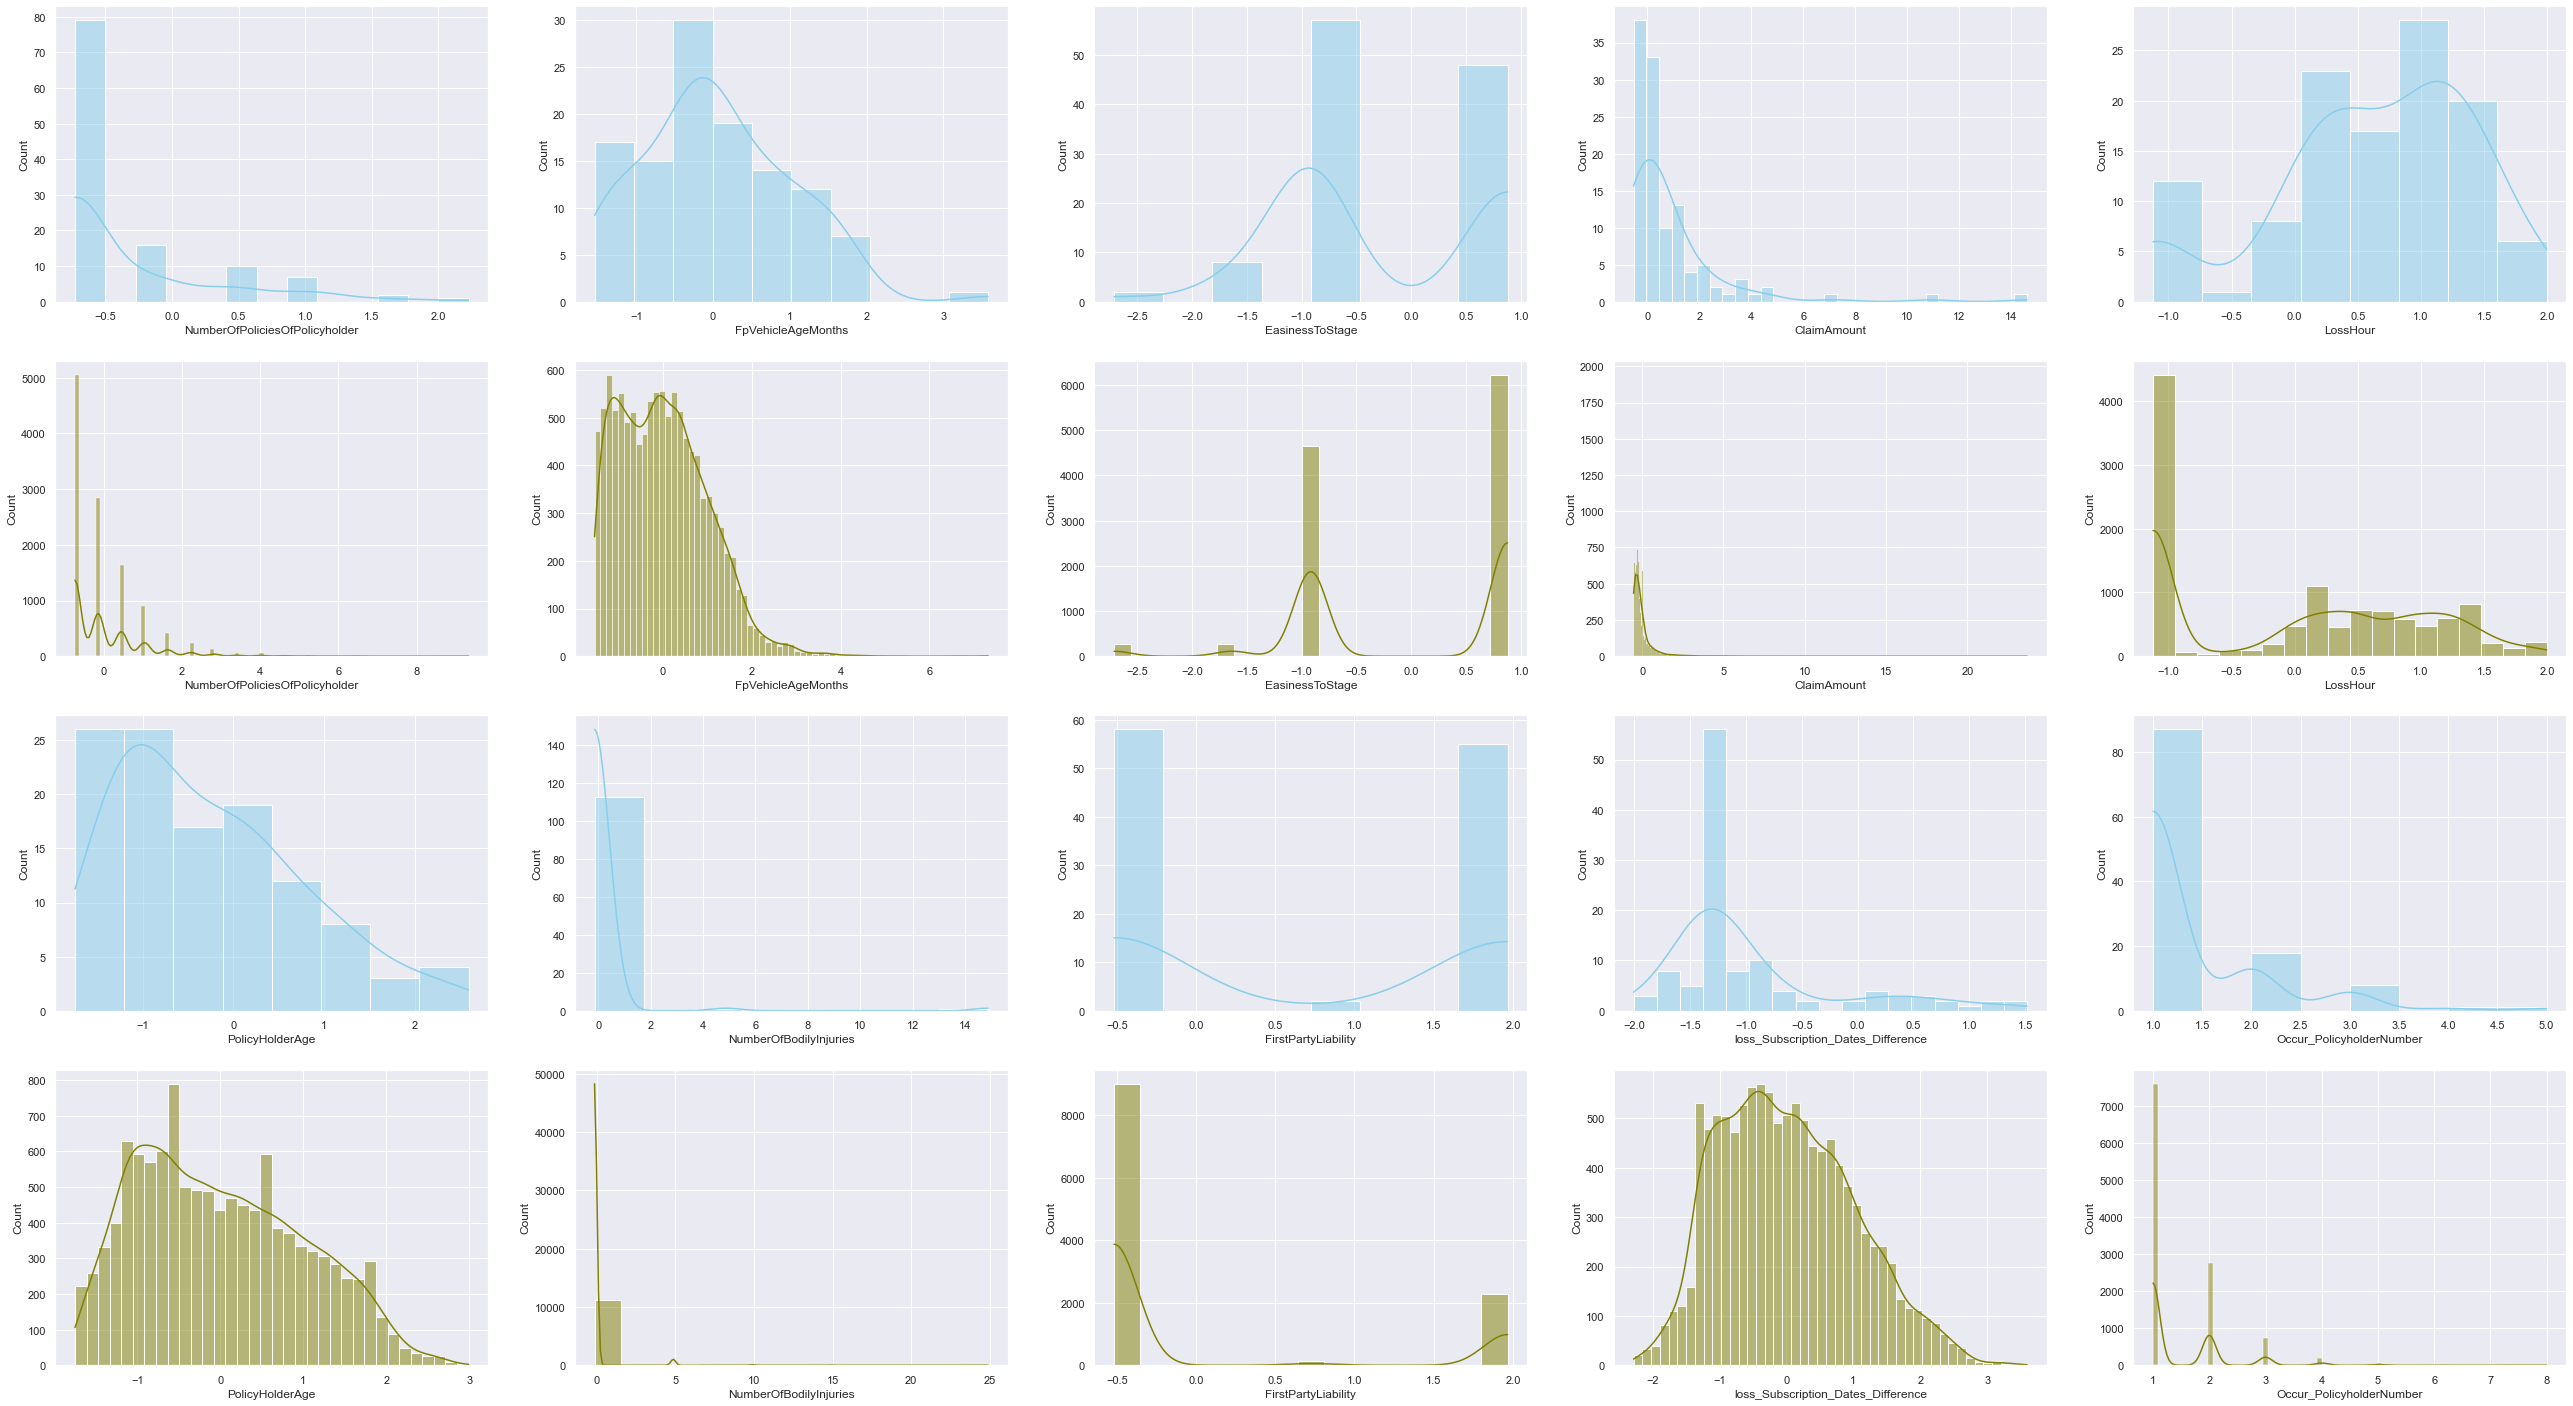

<Figure size 432x288 with 0 Axes>

In [87]:
# plotting the variable of 1 and 0 of distribution (after preprocessing)
# Note rthat we take a look at the scalar data (but not really apply the scalar here, we should apply after the split)
filepath='Insurance_claims.csv'
df_raw=pd.read_csv(filepath)
df_plot = preprocesssing(df_raw)

numeric_columns = [
    "loss_Subscription_Dates_Difference", "NumberOfPoliciesOfPolicyholder",'NumberOfBodilyInjuries',
    'FpVehicleAgeMonths', 'ClaimAmount', 'LossHour', 'PolicyHolderAge','EasinessToStage','FirstPartyLiability'
]
scaler = StandardScaler()
df_plot[numeric_columns] = scaler.fit_transform(df_plot[numeric_columns])

sns.set(style="darkgrid")
fig, axs = plt.subplots(4, 5, figsize=(45, 25))
                   
sns.histplot(data=df_plot[df_plot['Fraud']==1], x="NumberOfPoliciesOfPolicyholder", kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=df_plot[df_plot['Fraud']==1], x="FpVehicleAgeMonths", kde=True, color="skyblue", ax=axs[0, 1])
sns.histplot(data=df_plot[df_plot['Fraud']==1], x="EasinessToStage", kde=True, color="skyblue", ax=axs[0, 2])
sns.histplot(data=df_plot[df_plot['Fraud']==1], x="ClaimAmount", kde=True, color="skyblue", ax=axs[0, 3])
sns.histplot(data=df_plot[df_plot['Fraud']==1], x="LossHour", kde=True, color="skyblue", ax=axs[0, 4])
sns.histplot(data=df_plot[df_plot['Fraud']==0], x="NumberOfPoliciesOfPolicyholder", kde=True, color="olive", ax=axs[1, 0])
sns.histplot(data=df_plot[df_plot['Fraud']==0], x="FpVehicleAgeMonths", kde=True, color="olive", ax=axs[1, 1])
sns.histplot(data=df_plot[df_plot['Fraud']==0], x="EasinessToStage", kde=True, color="olive", ax=axs[1, 2])
sns.histplot(data=df_plot[df_plot['Fraud']==0], x="ClaimAmount", kde=True, color="olive", ax=axs[1, 3])
sns.histplot(data=df_plot[df_plot['Fraud']==0], x="LossHour", kde=True, color="olive", ax=axs[1, 4])


sns.histplot(data=df_plot[df_plot['Fraud']==1], x="PolicyHolderAge", kde=True, color="skyblue", ax=axs[2, 0])
sns.histplot(data=df_plot[df_plot['Fraud']==1], x="NumberOfBodilyInjuries", kde=True, color="skyblue", ax=axs[2, 1])
sns.histplot(data=df_plot[df_plot['Fraud']==1], x="FirstPartyLiability", kde=True, color="skyblue", ax=axs[2, 2])
sns.histplot(data=df_plot[df_plot['Fraud']==1], x="loss_Subscription_Dates_Difference", kde=True, color="skyblue", ax=axs[2, 3])
sns.histplot(data=df_plot[df_plot['Fraud']==1], x="Occur_PolicyholderNumber", kde=True, color="skyblue", ax=axs[2, 4])
sns.histplot(data=df_plot[df_plot['Fraud']==0], x="PolicyHolderAge", kde=True, color="olive", ax=axs[3, 0])
sns.histplot(data=df_plot[df_plot['Fraud']==0], x="NumberOfBodilyInjuries", kde=True, color="olive", ax=axs[3, 1])
sns.histplot(data=df_plot[df_plot['Fraud']==0], x="FirstPartyLiability", kde=True, color="olive", ax=axs[3, 2])
sns.histplot(data=df_plot[df_plot['Fraud']==0], x="loss_Subscription_Dates_Difference", kde=True, color="olive", ax=axs[3, 3])
sns.histplot(data=df_plot[df_plot['Fraud']==0], x="Occur_PolicyholderNumber", kde=True, color="olive", ax=axs[3, 4])


plt.figure()

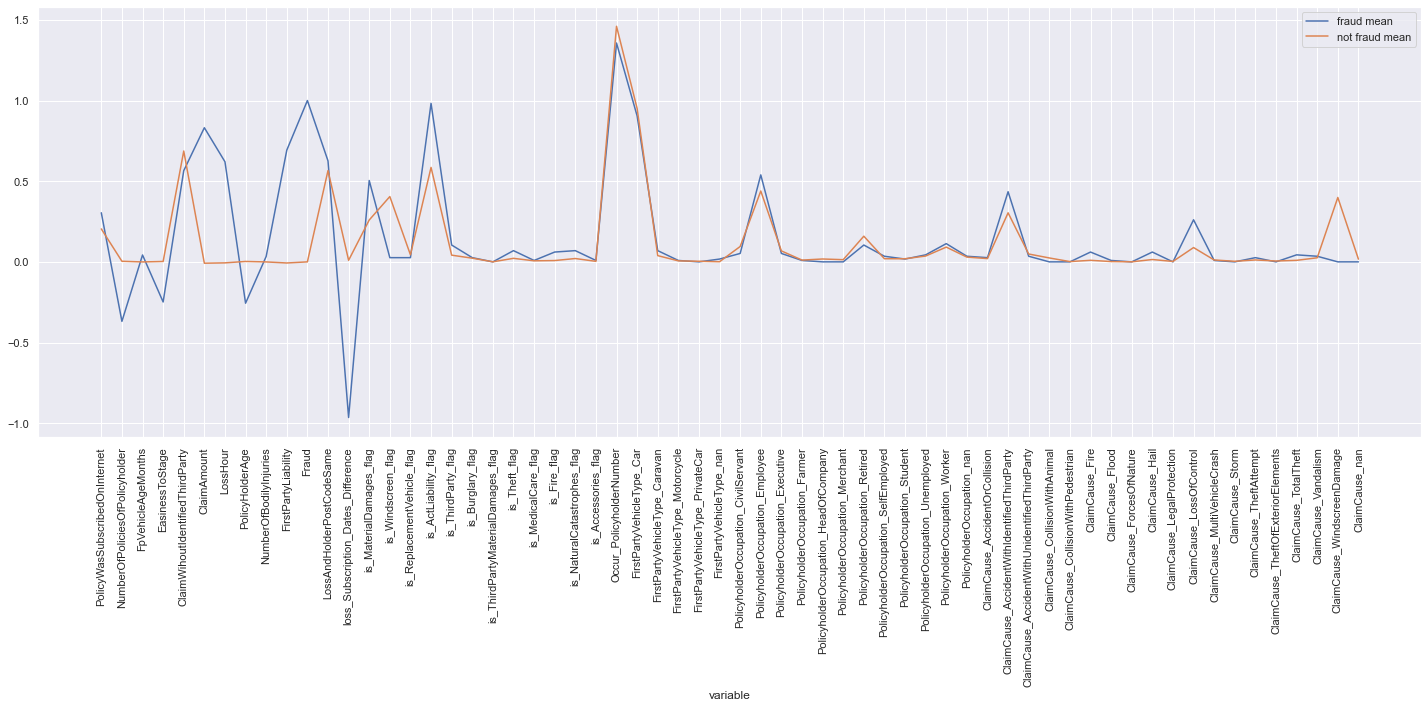

In [88]:
# see all the features differences of 0 and 1 with the mean (after preprocessing)
df_Fraud_describe  = df_plot[df_plot['Fraud']==1].describe()
df_not_Fraud_describe  = df_plot[df_plot['Fraud']==0].describe()
df_fraud_mean = df_Fraud_describe.iloc[1:2]
df_not_fraud_mean = df_not_Fraud_describe.iloc[1:2]

df_not_fraud_mean_transposed = df_not_fraud_mean.T 
df_fraud_mean_transposed = df_fraud_mean.T 
df_fraud_mean_transposed['variable'] = df_fraud_mean_transposed.index
df_not_fraud_mean_transposed['variable'] = df_not_fraud_mean_transposed.index
df_fraud_mean_transposed = df_fraud_mean_transposed.rename(columns={'mean': 'fraud mean'}, index={'variable': 'variable'})
df_not_fraud_mean_transposed = df_not_fraud_mean_transposed.rename(columns={'mean': 'not fraud mean'}, index={'variable': 'variable'})

plt.rcParams["figure.figsize"] = [20, 10]
plt.rcParams["figure.autolayout"] = True

ax = df_fraud_mean_transposed.plot(x='variable', y='fraud mean')
df_not_fraud_mean_transposed.plot(ax=ax, x='variable', y='not fraud mean')

plt.xticks(range(len(df_fraud_mean_transposed['variable'])),list(df_fraud_mean_transposed['variable']),rotation=90)
plt.show()

### Benchmarking the performance of different classifiers on the dataset
Start by creating a (deep) neural network in TensorFlow and train it on the data. Using training and validation sets, find a model with high accuracy, and evaluate it on the test set.

To make a valid comparison with the preceding models, the neural network was built by using the Keras hyper parameter tuning implemented on SMOTE tuner below. The model gave a accuracy rate of 0.9899 and Auc Score of 0.8869. True positive rate and true negative rate created by a predefined threshold of 0.001 were also recorded , 0.2822 and 0.9655 separately.

The following issues were observed based on the metrics:

- As mention above, these metrics were not indicative and they lost their meaning given an imbalanced data (100: 1). A random choose in the data set would also make a 99% accuracy.
- The gap between the true positive and true nagtive is very large. Classifier simply predicted the majority of the label but ignore the minority; therefore, the true positive rate (fraudulent) was 0.2822. 

In [135]:
#read the file 
filepath='Insurance_claims.csv'
df_raw=pd.read_csv(filepath)
df = preprocesssing(df_raw)

In [136]:
y = df['Fraud'] # 1 in the case of fraud; 0 otherwise
X = df.drop(columns='Fraud')

# split training, validation and test sets
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, y, train_size=0.75, random_state=461)

X_train, X_valid, Y_train, Y_valid = train_test_split(X_train_val, Y_train_val, train_size = 0.8, random_state=461)
X_train.shape, X_valid.shape , X_test.shape

numeric_columns = [
    "loss_Subscription_Dates_Difference", "NumberOfPoliciesOfPolicyholder",'NumberOfBodilyInjuries',
    'FpVehicleAgeMonths', 'ClaimAmount', 'LossHour', 'PolicyHolderAge','EasinessToStage','FirstPartyLiability'
]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_valid[numeric_columns] = scaler.transform(X_valid[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

In [137]:
# clean sessions and set seeds
tf.keras.backend.clear_session()
np.random.seed(231)
tf.random.set_seed(631)

In [138]:
# create tensorflow model
model_Q3 = tf.keras.models.Sequential([ 
    tf.keras.layers.Dense(20, kernel_initializer = 'uniform',activation="relu", input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(20, kernel_initializer = 'uniform',activation="relu"),
    tf.keras.layers.Dense(1, kernel_initializer = 'uniform', activation="sigmoid")
    ])

In [181]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# compile the model
model_Q3.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              metrics=["accuracy"])

# keep track of the perforance
log = model_Q3.fit(X_train, Y_train, 
                epochs=100, 
                validation_data=(X_valid, Y_valid),
               )



print("MSE on test set: " + str(model_Q3.evaluate(X_test, Y_test)))

# save the trained model 
model_Q3.save("original_turning_model.h5")

Epoch 1/100
216/216 [==============================] - 1s 2ms/step - loss: 0.0480 - accuracy: 0.9893 - val_loss: 0.0321 - val_accuracy: 0.9931
Epoch 2/100
216/216 [==============================] - 0s 1ms/step - loss: 0.0479 - accuracy: 0.9893 - val_loss: 0.0321 - val_accuracy: 0.9931
Epoch 3/100
216/216 [==============================] - 0s 1ms/step - loss: 0.0479 - accuracy: 0.9893 - val_loss: 0.0320 - val_accuracy: 0.9931
Epoch 4/100
216/216 [==============================] - 0s 1ms/step - loss: 0.0478 - accuracy: 0.9893 - val_loss: 0.0320 - val_accuracy: 0.9931
Epoch 5/100
216/216 [==============================] - 0s 1ms/step - loss: 0.0478 - accuracy: 0.9893 - val_loss: 0.0320 - val_accuracy: 0.9931
Epoch 6/100
216/216 [==============================] - 0s 1ms/step - loss: 0.0478 - accuracy: 0.9893 - val_loss: 0.0320 - val_accuracy: 0.9931
Epoch 7/100
216/216 [==============================] - 0s 1ms/step - loss: 0.0477 - accuracy: 0.9893 - val_loss: 0.0320 - val_accuracy: 0.9931

Epoch 58/100
216/216 [==============================] - 0s 1ms/step - loss: 0.0463 - accuracy: 0.9893 - val_loss: 0.0309 - val_accuracy: 0.9931
Epoch 59/100
216/216 [==============================] - 0s 1ms/step - loss: 0.0462 - accuracy: 0.9893 - val_loss: 0.0309 - val_accuracy: 0.9931
Epoch 60/100
216/216 [==============================] - 0s 1ms/step - loss: 0.0462 - accuracy: 0.9893 - val_loss: 0.0309 - val_accuracy: 0.9931
Epoch 61/100
216/216 [==============================] - 0s 1ms/step - loss: 0.0462 - accuracy: 0.9893 - val_loss: 0.0309 - val_accuracy: 0.9931
Epoch 62/100
216/216 [==============================] - 0s 1ms/step - loss: 0.0461 - accuracy: 0.9893 - val_loss: 0.0309 - val_accuracy: 0.9931
Epoch 63/100
216/216 [==============================] - 0s 1ms/step - loss: 0.0461 - accuracy: 0.9893 - val_loss: 0.0309 - val_accuracy: 0.9931
Epoch 64/100
216/216 [==============================] - 0s 1ms/step - loss: 0.0461 - accuracy: 0.9893 - val_loss: 0.0309 - val_accuracy:

In [144]:
model_Q3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                1240      
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1,681
Trainable params: 1,681
Non-trainable params: 0
_________________________________________________________________


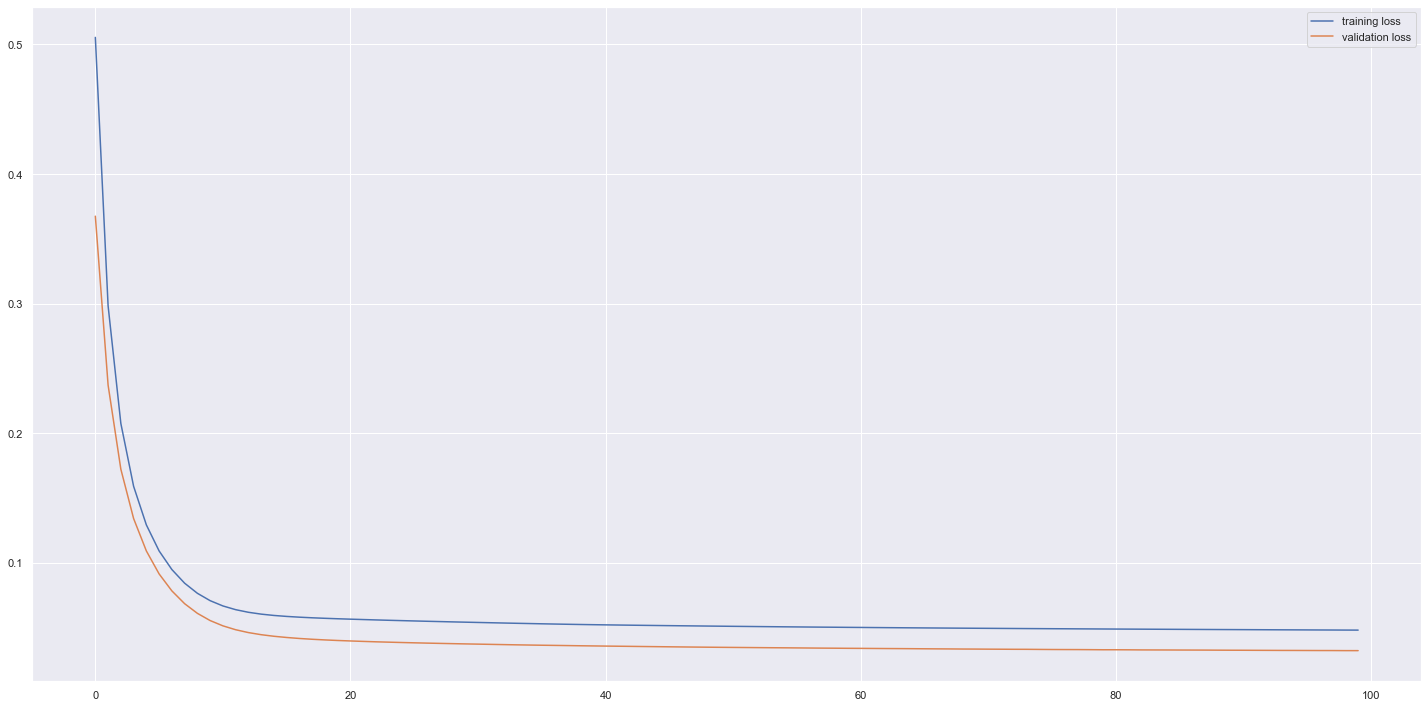

In [145]:
# visualise the lost 
plt.plot(log.history['loss'],label = "training loss")
plt.plot(log.history['val_loss'], label = "validation loss")
plt.legend()
plt.show()

In [146]:
# evalute the model on test set
model_Q3.evaluate(X_test, Y_test)

91/91 [==============================] - 0s 870us/step - loss: 0.0455 - accuracy: 0.9899


[0.045471351593732834, 0.9899340271949768]

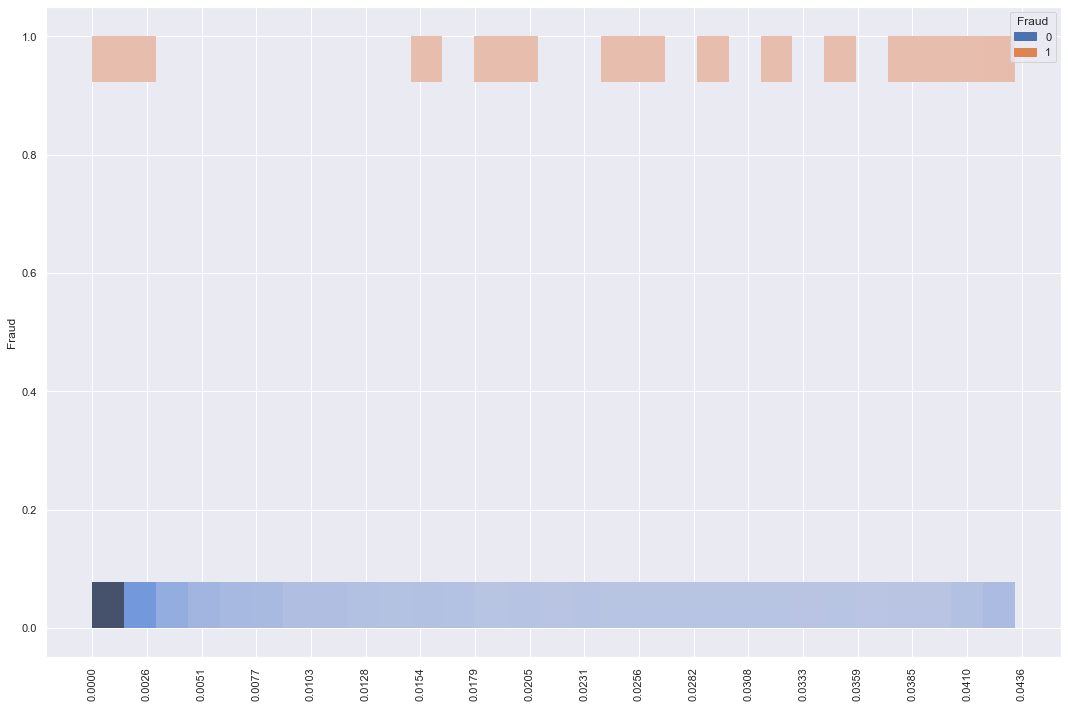

In [147]:
# make prediction on test set
Y_prob = model_Q3.predict(X_test)
Y_prob = Y_prob.reshape(-1,)
Y_prob = [ y for y in Y_prob]

tuples_Y_test = list(zip(Y_prob,Y_test))
df_Y_test = pd.DataFrame(tuples_Y_test, columns=['Y_prob','Y_test'])

fig=plt.figure(figsize=(15,10))
fig.add_subplot(111)
plt.xticks(np.linspace(0,0.1,40,endpoint=True),rotation=90)
sns.histplot(x=Y_prob,y=Y_test.squeeze(),hue=Y_test)
plt.tight_layout()
plt.show()

In [148]:
# get the AUC score
roc_auc_score(Y_test, Y_prob)

0.8869879576340862

In [160]:
# set treshold and get the final result    
threshold = 0.001
Y_predict = np.where(np.array(Y_prob)>=threshold, 1, 0)

# create confusion matrix 
cm = confusion_matrix(Y_test, Y_predict)
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TP = cm[1][1]
# print out the true positive and negative rate
print('true negative rate is ' + str(TN/(FP+TN)))
print('true positive rate is ' + str(TP/(TP+FN)))

true negative rate is 0.28225806451612906
true positive rate is 0.9655172413793104


### (Synthetic) Data Points
Our first approach will be to create new (synthetic) data points representing fraudulent claims and remove some of the non-fraudulent claims. This will allow us to create a more balanced dataset. The state-of-the-art method we apply is SMOTE (Synthetic Minority Oversampling Technique).


A combination of SMOTE oversampling and undersampling methods is applied to create a balance of 50:50 for both fraud and non-fraud classes. The concept is because we apply a modest amount of oversampling to the minority class, which improves the bias to the minority class instances, whilst we also perform a modest amount of undersampling on the majority class to reduce the bias on the majority class instances. As we performed both SMOTE and undersampling, the total number of instances of synthesized dataset is close to that of the original dataset. By doing this, we could improve performance in comparison to the methods being performed in isolation. 

In [182]:
# create a SMOTE sampler to increase minority class observations to 50%    ###這邊有問題是要55分嗎
over = imblearn.over_sampling.SMOTE(sampling_strategy=0.5, random_state = 483)

# add a RandomUnderSampler, using sampling_startegy = 1 to get 50% of our observations in the minority class
under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=1, random_state = 241)
steps = [('o', over), ('u', under)]
#use a Pipeline to combine the steps:
pipeline = imblearn.pipeline.Pipeline(steps=steps)
X_synth, Y_synth = pipeline.fit_resample(X_train, Y_train)

In [183]:
print(f'''Shape of X_train before SMOTE: {X_train.shape}
Shape of X_train after SMOTE: {X_synth.shape}''')
print(f'''Shape of y_train before SMOTE: {Y_train.shape}
Shape of y_train after SMOTE: {Y_synth.shape}''')
print('\nBalance of positive and negative classes (%):')
Y_synth.value_counts(normalize=True) * 100

# check new class distribution
counter = Counter(Y_synth)
print(counter)

Shape of X_train before SMOTE: (6912, 61)
Shape of X_train after SMOTE: (6838, 61)
Shape of y_train before SMOTE: (6912,)
Shape of y_train after SMOTE: (6838,)

Balance of positive and negative classes (%):
Counter({0: 3419, 1: 3419})


### Create a new (deep) neural network and train it on the enhanced dataset. Use training and validation sets derived from the enhanced dataset to find a model with high accuracy. Evaluate the final model on a test set consisting only of original data.


After applying smote, the accuracy rate and auc are expected to drop and the gap between true positive and true nagative are also expected to narrow, compared with above benchmark model because metrics are now indicative and algorithm has sufficient look at the underlying class and treat all observation of fradulent and non-fraudulent the same. Furthermore, even with balanced data, it is impossible to achieve a 99% true positive rate in real life. The actual outcome matched with previous expectation with a accuracy rate of 0.9611, auc 0.8341 and true positive rate and true negative rate 

The first benchmark model is doing better on predicting fraudulent; however, the limitation on the smote and under-sampling is that it generates new data set based on the characters of the current fraudulent cases which might not be representative for all the fraudulent characteristics and therefore the prediction is difficult to reach a very good level such as above 95%.


In [184]:
# split training, validation and test sets
X_train_2, X_valid_2, Y_train_2, Y_valid_2 = train_test_split(X_synth, Y_synth, train_size=0.8, random_state=461)

In [185]:
# clean sessions and set seeds
tf.keras.backend.clear_session()
np.random.seed(231)
tf.random.set_seed(631)

In [186]:
# build a hyper parameter function to tune the parameters
def train_model_Q5(hp):      
       
   # find the best hidden layer size
    model = tf.keras.models.Sequential()
    
     # tune the number of layers.
    for i in range(hp.Int('num_layers', 1, 5)):
        model.add(tf.keras.layers.Dense(
            # tune number of units separatel and set max and min value for nuron
            units=hp.Int(f"num_units_{i}", min_value = 2, max_value=61),
            # apply L2 reugularizaton to prevent overfittinng issue
            kernel_regularizer=tf.keras.regularizers.l2(0.01),
            activation='relu'))
    
    # tune whether to use dropout for layers 
    if hp.Boolean("dropout"):
        # set a drop out rate ranging from 0.1 to 03
        model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout_rate', min_value = 0.1, max_value=0.3)))
        
    # add output layer 
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    # define a choice of optimizer 
    optim_algo = hp.Choice('optimizer', values=['sgd','adam']) 
    # define the range of learning rate 
    learning_rate = hp.Float('learning_rate', min_value=0.001, max_value=1, sampling="log")
    
    # tune wether to use sgd or adam optimizer 
    if optim_algo == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate,clipvalue=1)
    elif optim_algo == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    # compile the model    
    model.compile(  optimizer=optimizer,
                    # add loss function, in this case, the result will be binary 
                    loss='binary_crossentropy',
                    # define metrics to show 
                    metrics=["accuracy", 
                            tf.keras.metrics.TruePositives(name="tp"),
                            tf.keras.metrics.AUC(name='auc')
                            ])
    return model

train_model_Q5(kt.HyperParameters())

In [187]:
# create tunner
tuner = kt.Hyperband(train_model_Q5,
                     # set an obejective of minimise loss
                     objective='val_loss',
                     max_epochs=40,
                     factor=3,
                     seed=235
#                      directory='/Users/user/Desktop/ADL',
#                      project_name='smote_turner_question5_test_spliting difference'
                    )
# find the best values
tuner.search(X_train_2, Y_train_2, validation_data=(X_valid_2,Y_valid_2))

INFO:tensorflow:Reloading Oracle from existing project /Users/user/Desktop/ADL/smote_turner_question5_test_spliting difference/oracle.json
INFO:tensorflow:Reloading Tuner from /Users/user/Desktop/ADL/smote_turner_question5_test_spliting difference/tuner0.json
INFO:tensorflow:Oracle triggered exit


In [188]:
# get the best hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]

# print out the best parameters
print("\033[1m---------------------Best Parameters---------------------\033[0m")
print("Best number of hidden layers: " + str(best_hps['num_layers']))
print("Best learning rate: " + str(best_hps['learning_rate']))
print("Best optimizer: " + str(best_hps['optimizer']))
print("Best dropout rate: " + str(best_hps['dropout_rate']))

---------------------Best Parameters---------------------
Best number of hidden layers: 3
Best learning rate: 0.0039038018390405746
Best optimizer: adam
Best dropout rate: 0.1627808416847248


In [189]:
# create the best model
model_Q5 = tuner.hypermodel.build(best_hps)

#create another model
log_2 = model_Q5.fit(X_train_2, Y_train_2,
               epochs=200,
               validation_data=(X_valid_2,Y_valid_2),)
#                callbacks=[early_stopping_cb])


print("MSE on test set: " + str(model_Q5.evaluate(X_test, Y_test)))

# save the trained model 
model_Q5.save("smote_turning_model.h5")

Epoch 1/200
171/171 [==============================] - 1s 3ms/step - loss: 0.6261 - accuracy: 0.8761 - tp: 2488.0000 - auc: 0.9345 - val_loss: 0.3450 - val_accuracy: 0.9313 - val_tp: 689.0000 - val_auc: 0.9697
Epoch 2/200
171/171 [==============================] - 0s 1ms/step - loss: 0.3103 - accuracy: 0.9322 - tp: 2612.0000 - auc: 0.9745 - val_loss: 0.2794 - val_accuracy: 0.9466 - val_tp: 670.0000 - val_auc: 0.9829
Epoch 3/200
171/171 [==============================] - 0s 2ms/step - loss: 0.2682 - accuracy: 0.9431 - tp: 2624.0000 - auc: 0.9815 - val_loss: 0.2597 - val_accuracy: 0.9496 - val_tp: 686.0000 - val_auc: 0.9780
Epoch 4/200
171/171 [==============================] - 0s 2ms/step - loss: 0.2467 - accuracy: 0.9486 - tp: 2641.0000 - auc: 0.9838 - val_loss: 0.2362 - val_accuracy: 0.9488 - val_tp: 691.0000 - val_auc: 0.9846
Epoch 5/200
171/171 [==============================] - 0s 2ms/step - loss: 0.2374 - accuracy: 0.9505 - tp: 2634.0000 - auc: 0.9848 - val_loss: 0.2251 - val_accu

Epoch 40/200
171/171 [==============================] - 0s 2ms/step - loss: 0.1626 - accuracy: 0.9664 - tp: 2657.0000 - auc: 0.9933 - val_loss: 0.1773 - val_accuracy: 0.9656 - val_tp: 683.0000 - val_auc: 0.9894
Epoch 41/200
171/171 [==============================] - 0s 2ms/step - loss: 0.1774 - accuracy: 0.9636 - tp: 2650.0000 - auc: 0.9915 - val_loss: 0.1673 - val_accuracy: 0.9649 - val_tp: 694.0000 - val_auc: 0.9937
Epoch 42/200
171/171 [==============================] - 0s 2ms/step - loss: 0.1605 - accuracy: 0.9697 - tp: 2664.0000 - auc: 0.9932 - val_loss: 0.1609 - val_accuracy: 0.9671 - val_tp: 687.0000 - val_auc: 0.9929
Epoch 43/200
171/171 [==============================] - 0s 2ms/step - loss: 0.1790 - accuracy: 0.9583 - tp: 2633.0000 - auc: 0.9912 - val_loss: 0.2178 - val_accuracy: 0.9408 - val_tp: 636.0000 - val_auc: 0.9923
Epoch 44/200
171/171 [==============================] - 0s 2ms/step - loss: 0.1603 - accuracy: 0.9691 - tp: 2671.0000 - auc: 0.9938 - val_loss: 0.1659 - val

Epoch 79/200
171/171 [==============================] - 0s 2ms/step - loss: 0.1547 - accuracy: 0.9665 - tp: 2654.0000 - auc: 0.9937 - val_loss: 0.1616 - val_accuracy: 0.9620 - val_tp: 674.0000 - val_auc: 0.9938
Epoch 80/200
171/171 [==============================] - 0s 2ms/step - loss: 0.1548 - accuracy: 0.9680 - tp: 2662.0000 - auc: 0.9934 - val_loss: 0.1448 - val_accuracy: 0.9678 - val_tp: 694.0000 - val_auc: 0.9961
Epoch 81/200
171/171 [==============================] - 0s 2ms/step - loss: 0.1490 - accuracy: 0.9707 - tp: 2661.0000 - auc: 0.9938 - val_loss: 0.1879 - val_accuracy: 0.9547 - val_tp: 647.0000 - val_auc: 0.9931
Epoch 82/200
171/171 [==============================] - 0s 2ms/step - loss: 0.1532 - accuracy: 0.9673 - tp: 2657.0000 - auc: 0.9936 - val_loss: 0.1740 - val_accuracy: 0.9583 - val_tp: 696.0000 - val_auc: 0.9910
Epoch 83/200
171/171 [==============================] - 0s 2ms/step - loss: 0.1433 - accuracy: 0.9740 - tp: 2677.0000 - auc: 0.9943 - val_loss: 0.1593 - val

Epoch 118/200
171/171 [==============================] - 0s 2ms/step - loss: 0.1421 - accuracy: 0.9713 - tp: 2664.0000 - auc: 0.9943 - val_loss: 0.1810 - val_accuracy: 0.9576 - val_tp: 698.0000 - val_auc: 0.9894
Epoch 119/200
171/171 [==============================] - 0s 2ms/step - loss: 0.1572 - accuracy: 0.9654 - tp: 2650.0000 - auc: 0.9926 - val_loss: 0.1584 - val_accuracy: 0.9656 - val_tp: 695.0000 - val_auc: 0.9937
Epoch 120/200
171/171 [==============================] - 0s 2ms/step - loss: 0.1494 - accuracy: 0.9687 - tp: 2657.0000 - auc: 0.9927 - val_loss: 0.1665 - val_accuracy: 0.9642 - val_tp: 662.0000 - val_auc: 0.9940
Epoch 121/200
171/171 [==============================] - 0s 2ms/step - loss: 0.1456 - accuracy: 0.9682 - tp: 2662.0000 - auc: 0.9940 - val_loss: 0.1523 - val_accuracy: 0.9751 - val_tp: 683.0000 - val_auc: 0.9936
Epoch 122/200
171/171 [==============================] - 0s 2ms/step - loss: 0.1482 - accuracy: 0.9686 - tp: 2657.0000 - auc: 0.9930 - val_loss: 0.1729 

Epoch 157/200
171/171 [==============================] - 0s 2ms/step - loss: 0.1407 - accuracy: 0.9746 - tp: 2672.0000 - auc: 0.9939 - val_loss: 0.1493 - val_accuracy: 0.9730 - val_tp: 687.0000 - val_auc: 0.9923
Epoch 158/200
171/171 [==============================] - 0s 3ms/step - loss: 0.1425 - accuracy: 0.9740 - tp: 2674.0000 - auc: 0.9937 - val_loss: 0.1530 - val_accuracy: 0.9649 - val_tp: 688.0000 - val_auc: 0.9927
Epoch 159/200
171/171 [==============================] - 0s 2ms/step - loss: 0.1539 - accuracy: 0.9653 - tp: 2646.0000 - auc: 0.9929 - val_loss: 0.1571 - val_accuracy: 0.9693 - val_tp: 696.0000 - val_auc: 0.9926
Epoch 160/200
171/171 [==============================] - 0s 2ms/step - loss: 0.1462 - accuracy: 0.9695 - tp: 2656.0000 - auc: 0.9934 - val_loss: 0.1660 - val_accuracy: 0.9605 - val_tp: 698.0000 - val_auc: 0.9948
Epoch 161/200
171/171 [==============================] - 0s 2ms/step - loss: 0.1422 - accuracy: 0.9718 - tp: 2663.0000 - auc: 0.9938 - val_loss: 0.1739 

Epoch 196/200
171/171 [==============================] - 0s 2ms/step - loss: 0.1626 - accuracy: 0.9636 - tp: 2648.0000 - auc: 0.9912 - val_loss: 0.1645 - val_accuracy: 0.9656 - val_tp: 693.0000 - val_auc: 0.9901
Epoch 197/200
171/171 [==============================] - 0s 2ms/step - loss: 0.1374 - accuracy: 0.9724 - tp: 2666.0000 - auc: 0.9950 - val_loss: 0.1473 - val_accuracy: 0.9671 - val_tp: 693.0000 - val_auc: 0.9934
Epoch 198/200
171/171 [==============================] - 0s 2ms/step - loss: 0.1463 - accuracy: 0.9717 - tp: 2670.0000 - auc: 0.9930 - val_loss: 0.1519 - val_accuracy: 0.9700 - val_tp: 681.0000 - val_auc: 0.9936
Epoch 199/200
171/171 [==============================] - 0s 2ms/step - loss: 0.1529 - accuracy: 0.9649 - tp: 2650.0000 - auc: 0.9926 - val_loss: 0.1485 - val_accuracy: 0.9700 - val_tp: 688.0000 - val_auc: 0.9933
Epoch 200/200
91/91 [==============================] - 0s 1ms/step - loss: 0.1723 - accuracy: 0.9611 - tp: 8.0000 - auc: 0.7660
MSE on test set: [0.1722

In [190]:
model_Q5.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 41)                2542      
                                                                 
 dense_5 (Dense)             (None, 36)                1512      
                                                                 
 dense_6 (Dense)             (None, 55)                2035      
                                                                 
 dense_7 (Dense)             (None, 1)                 56        
                                                                 
Total params: 6,145
Trainable params: 6,145
Non-trainable params: 0
_________________________________________________________________


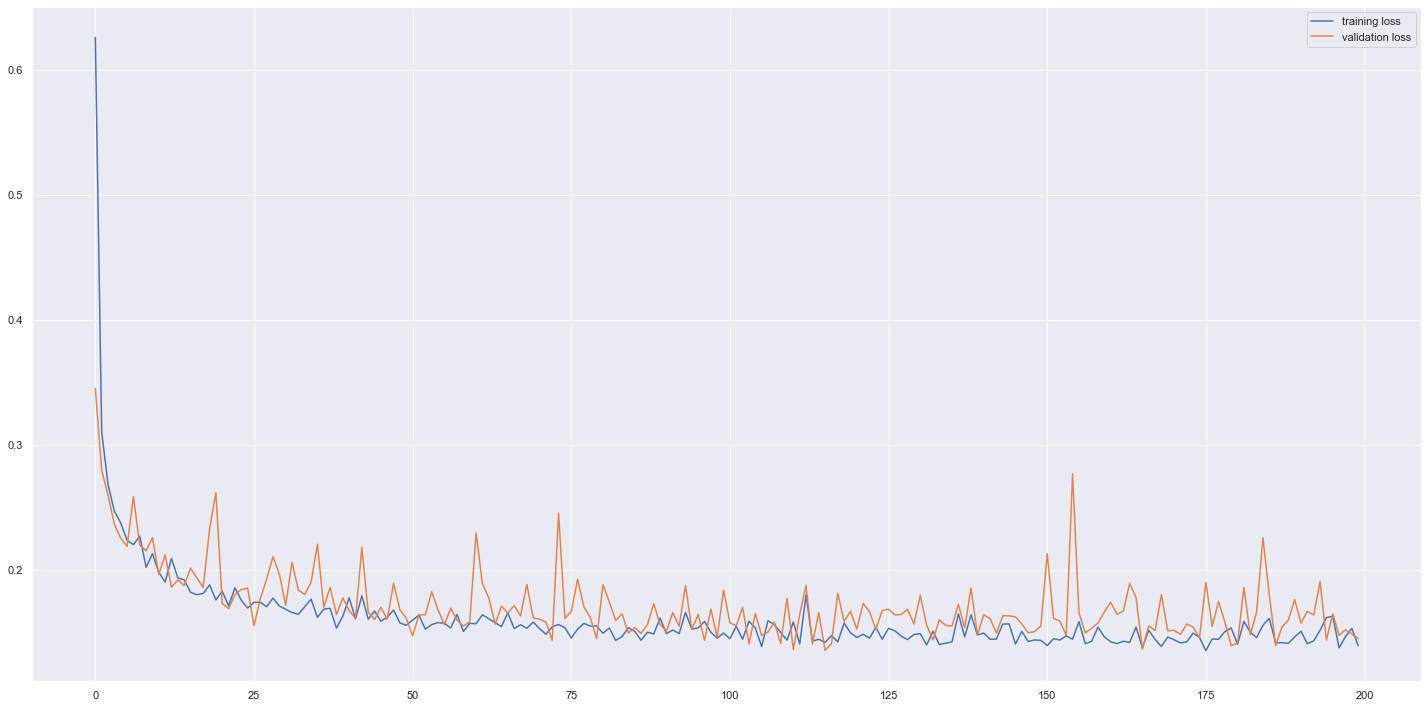

In [191]:
# visualise the lost 
plt.plot(log_2.history['loss'],label = "training loss")
plt.plot(log_2.history['val_loss'], label = "validation loss")
plt.legend()
plt.show()

In [192]:
# evalute the model on test set
model_Q5.evaluate(X_test, Y_test)

91/91 [==============================] - 0s 1ms/step - loss: 0.1723 - accuracy: 0.9611 - tp: 8.0000 - auc: 0.7660


[0.1722506880760193, 0.96112459897995, 8.0, 0.7659597396850586]

In [193]:
# make prediction on test set
Y_prob_2 = model_Q5.predict(X_test)
Y_prob_2 = Y_prob_2.reshape(-1,)
Y_prob_2 = [ y for y in Y_prob_2]

# get the AUC score
roc_auc_score(Y_test, Y_prob_2)

0.8341454272863569

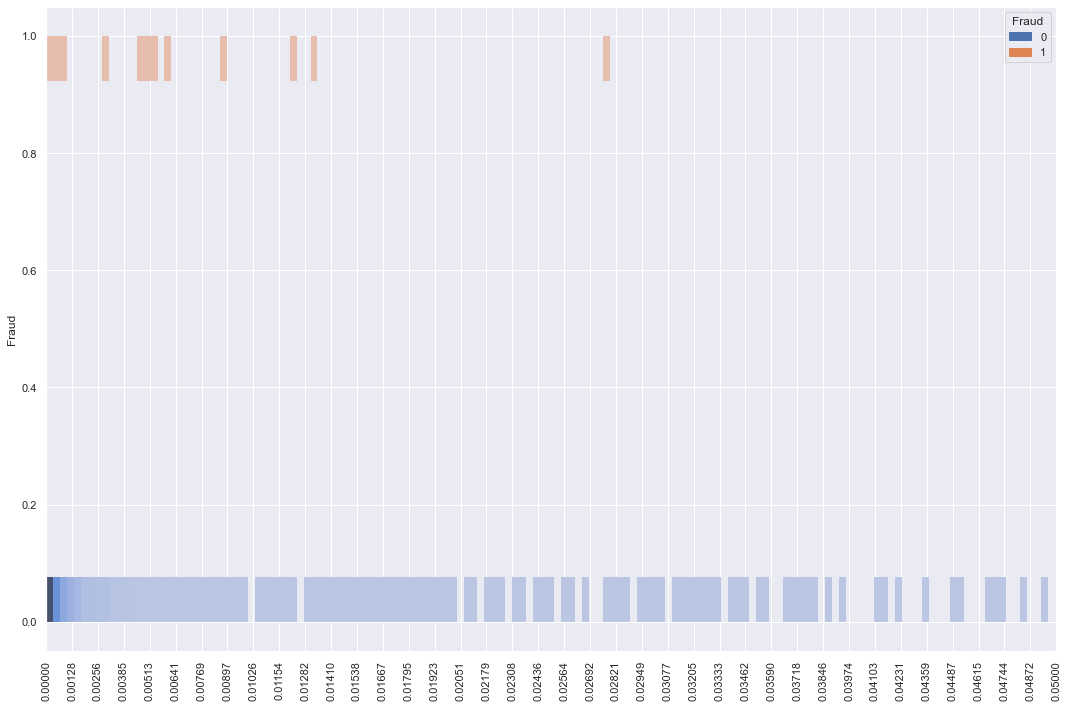

In [194]:
#picking up the threshold 
fig=plt.figure(figsize=(15,10))
fig.add_subplot(111)
plt.xticks(np.linspace(0,0.05,40,endpoint=True),rotation=90)
sns.histplot(x=Y_prob_2,y=Y_test.squeeze(),hue=Y_test)
plt.tight_layout()
plt.xlim([0, 0.05])
plt.show()

[(0.0, 1.0)]

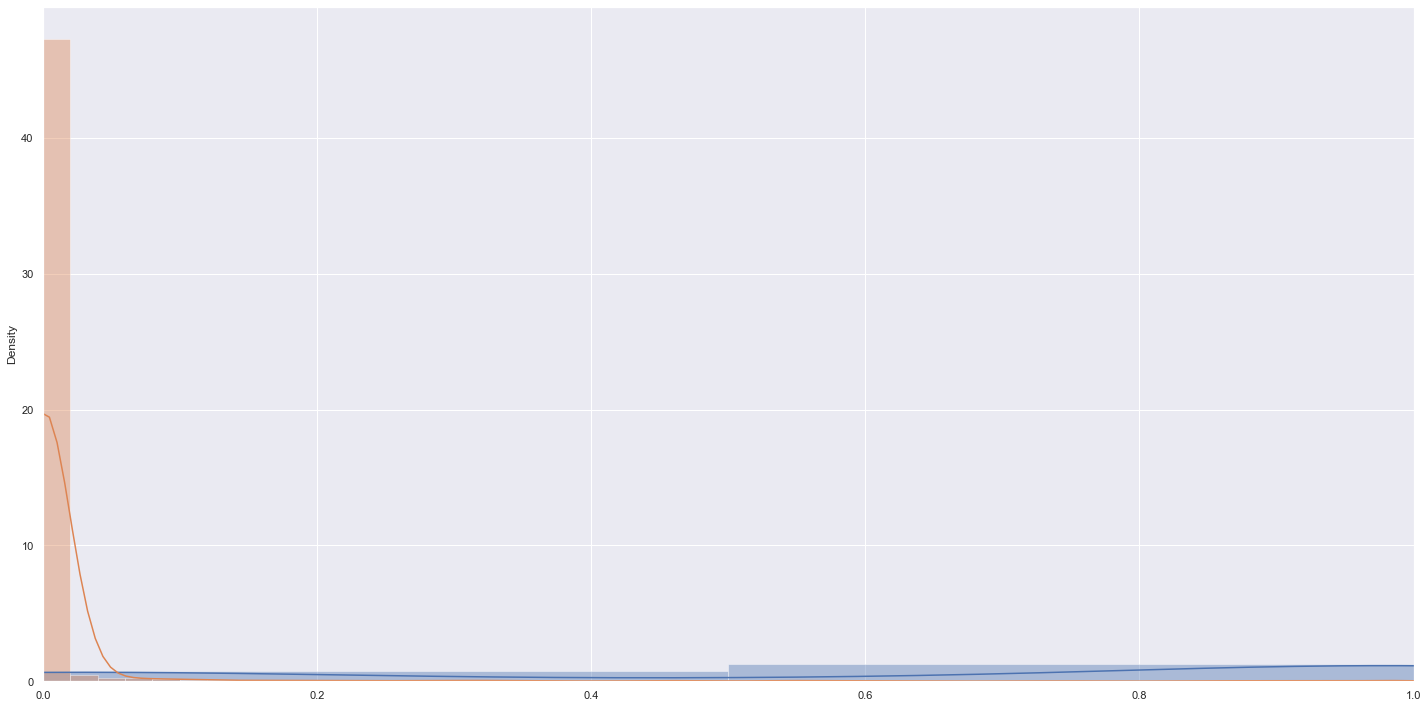

In [195]:
tuples_test_y  = zip(Y_test, Y_prob_2)
df_test_y = pd.DataFrame(tuples_test_y, columns = ['Y_test', 'Y_prob_2'])

sns.set_style('darkgrid')
hist = sns.distplot(df_test_y[df_test_y['Y_test']==1])
hist = sns.distplot(df_test_y[df_test_y['Y_test']==0])
hist.set(xlim=(0, 1))

In [196]:
# set treshold and get the final result 
# the treashold was found by observing the distribution of probability of Fradulent and Non-Fradulent
threshold = 0.003
Y_predict_2 = np.where(np.array(Y_prob_2)>=threshold, 1, 0)

# create confusion matrix 
cm = confusion_matrix(Y_test, Y_predict_2)
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TP = cm[1][1]

# print out the true positive and negative rate
print('True Negative rate (Sensitivity)' + str(TN/(FP+TN)))
print('True Positive rate (Specificity)' + str(TP/(TP+FN)))

True Negative rate (Sensitivity)0.7738429172510519
True Positive rate (Specificity)0.8275862068965517


### Autoencoder
Our second approach will be to use an autoencoder to learn what "normal" (non-fraudulent) data "looks like."

Using the original data, create a training and set that contains only non-fraudulent claims, as well as validation and test sets that contain non-fraudulent and fraudulent claims. Make sure to spread fraudulent claims evenly across validation and test sets.</b>

In this case, dataset is preprocessed as before. There's slight difference in dataset splitting. We at first selected all negative samples and split them into two parts at ratio of 3:7, the larger proportion of which is our training set. Then we concatenated the smaller part of negative samples and remaining positive samples and split them into validation set and test set evenly. There is no distribution imbalance as examined.
Considering negative samples and positive samples are likely to obey different distributions, it’s meaningless to scale test set with mean and variance of training set. Thus, we simply scaled the whole dataset before splitting.

In [210]:
filepath='Insurance_claims.csv'
df=pd.read_csv(filepath)
df = preprocesssing(df)

In [211]:
numeric_columns = [
    "loss_Subscription_Dates_Difference", "NumberOfPoliciesOfPolicyholder",'NumberOfBodilyInjuries',
    'FpVehicleAgeMonths', 'ClaimAmount', 'LossHour', 'PolicyHolderAge','EasinessToStage','FirstPartyLiability'
]
scaler = StandardScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

In [212]:
# clean sessions and set seeds
tf.keras.backend.clear_session()
np.random.seed(231)
tf.random.set_seed(631)

In [213]:
from pandas.core.common import random_state
seed=3
random_state=3

import random
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

In [214]:
df_fraud = df[df['Fraud'] == 1]
df_non_fraud = df[df['Fraud'] == 0]
X = df_non_fraud.drop(columns='Fraud').values
y = df_non_fraud['Fraud'].values

X_train, X_other, y_train, y_other = train_test_split(
    X, y, test_size=0.3, random_state=random_state)
X_valid = np.concatenate((df_fraud.drop(columns=['Fraud']).values, X_other),
                         axis=0)
y_valid = np.concatenate((df_fraud['Fraud'].values, y_other), axis=0)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid,
                                                    y_valid,
                                                    test_size=0.5,
                                                    random_state=random_state)

In [215]:
X_test.shape, y_test.shape, y_valid.shape

((1769, 61), (1769,), (1769,))

### Autoencoder NN model
Using TensorFlow, create an autoencoder, ensuring that the middle hidden layer has fewer neurons than the input has features. Use training and validation sets to find a model that represents its input data well.


We built a 5-layer autoencoder since it can keep majority of information in dataset and not too complex. Numbers of neurons in each hidden layer are tuned by Hyperband. With regard to other hyperparameter, we considered Adam weight decay optimizer, cosine annealing learning rate scheduler and loss function of MSE. This model obtained a AUC above 0.7 on validation set.

In [34]:
# set weight initializer, weight decay and learning rate
He_initializer = tf.keras.initializers.variance_scaling(mode='fan_avg')
num_epochs = 100
batch_size = 64
weight_decay = 1e-5
learning_rate = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=1e-2,
    first_decay_steps=(num_epochs / 1) * X_train.shape[0] // batch_size)

def train_model(hp):    
    num_units_1 = hp.Int('num_units_1', min_value = 49, max_value=60) 
    num_units_2 = hp.Int('num_units_2', min_value = 37, max_value=48) 
    num_units_3 = hp.Int('num_units_3', min_value = 25, max_value=36) 
    num_units_4 = hp.Int('num_units_4', min_value = 13, max_value=24)
    num_units_5 = hp.Int('num_units_5', min_value = 1, max_value=12)
    optim_algo = hp.Choice('optimizer', values=['sgd','adam']) 
    
    model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1], )),
    tf.keras.layers.Dense(num_units_1, kernel_initializer=He_initializer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(num_units_2, kernel_initializer=He_initializer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(num_units_3, kernel_initializer=He_initializer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(num_units_4, kernel_initializer=He_initializer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(num_units_5, kernel_initializer=He_initializer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(num_units_4, kernel_initializer=He_initializer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(num_units_3, kernel_initializer=He_initializer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(num_units_2, kernel_initializer=He_initializer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(num_units_1, kernel_initializer=He_initializer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(61, kernel_initializer=He_initializer)
])
    
    if optim_algo == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optim_algo == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        
    model.compile(optimizer=optimizer,
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.MeanSquaredError()])
    
    return model

hp_tuner = kt.Hyperband(train_model,
                     objective='val_loss',
                     max_epochs=50,
                     factor=3)

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


In [120]:
tf.keras.backend.clear_session()
# We try to use tuner to find the best solution:
hp_tuner.search(X_train,X_train,validation_data=(X_valid,X_valid))

Trial 90 Complete [00h 00m 45s]
val_loss: 0.14318083226680756

Best val_loss So Far: 0.02535504661500454
Total elapsed time: 00h 19m 59s
INFO:tensorflow:Oracle triggered exit


In [41]:
#the best units that tuner suggest:
best_hps=hp_tuner.get_best_hyperparameters()[0]
print(best_hps['num_units_1'])
print(best_hps['num_units_2'])
print(best_hps['num_units_3'])
print(best_hps['num_units_4'])
print(best_hps['num_units_5'])

50
44
35
22
8


We have used HPtuner to choose best combination of neuron numbers in different hidden layers. The issue was, we found different outputs which can obtain a 10% difference in AUC, when running same codes in different laptops, even in the same device different times. Our solution is to not clear session, fit same model repeatedly and save the model with highest AUC. In this case, we reached AUC at 0.76 with validation data and 0.72 at test data. In general, autoencoder can usually reach above 0.7 with tuned models.

Randomness problem: The ROC solution is not the same every time. After our observation, we found that Loss will be inherited according to the log after the last run. But we still can't solve this problem after we have fixed the seed.

In [62]:
#apply back to auto encoding model:
He_initializer = tf.keras.initializers.variance_scaling(mode='fan_avg')
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1], )),
    tf.keras.layers.Dense(50, kernel_initializer=He_initializer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(44, kernel_initializer=He_initializer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(35, kernel_initializer=He_initializer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(22, kernel_initializer=He_initializer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(8, kernel_initializer=He_initializer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(22, kernel_initializer=He_initializer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(35, kernel_initializer=He_initializer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(44, kernel_initializer=He_initializer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(50, kernel_initializer=He_initializer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(61, kernel_initializer=He_initializer)
])


num_epochs = 50
batch_size = 64
learning_rate = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=1e-2,
    first_decay_steps=(num_epochs / 1) * X_train.shape[0] // batch_size)
weight_decay = 1e-5
optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate,weight_decay=weight_decay)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.MeanSquaredError(), "accuracy"])

In [67]:
log_auto = model.fit(x=X_train,
          y=X_train,
          batch_size=batch_size,
          epochs=num_epochs,
          validation_data=(X_valid, X_valid))

Epoch 1/50
125/125 [==============================] - 0s 4ms/step - loss: 0.0253 - mean_squared_error: 0.0253 - accuracy: 0.7206 - val_loss: 0.0252 - val_mean_squared_error: 0.0252 - val_accuracy: 0.7270
Epoch 2/50
125/125 [==============================] - 0s 4ms/step - loss: 0.0244 - mean_squared_error: 0.0244 - accuracy: 0.7188 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - val_accuracy: 0.7942
Epoch 3/50
125/125 [==============================] - 0s 4ms/step - loss: 0.0241 - mean_squared_error: 0.0241 - accuracy: 0.7326 - val_loss: 0.0275 - val_mean_squared_error: 0.0275 - val_accuracy: 0.7558
Epoch 4/50
125/125 [==============================] - 0s 4ms/step - loss: 0.0242 - mean_squared_error: 0.0242 - accuracy: 0.7218 - val_loss: 0.0279 - val_mean_squared_error: 0.0279 - val_accuracy: 0.7360
Epoch 5/50
125/125 [==============================] - 0s 4ms/step - loss: 0.0237 - mean_squared_error: 0.0237 - accuracy: 0.7320 - val_loss: 0.0219 - val_mean_squared_error: 0.0219 - v

125/125 [==============================] - 1s 6ms/step - loss: 0.0195 - mean_squared_error: 0.0195 - accuracy: 0.7485 - val_loss: 0.0175 - val_mean_squared_error: 0.0175 - val_accuracy: 0.7954
Epoch 42/50
125/125 [==============================] - 1s 6ms/step - loss: 0.0191 - mean_squared_error: 0.0191 - accuracy: 0.7480 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_accuracy: 0.7841
Epoch 43/50
125/125 [==============================] - 1s 6ms/step - loss: 0.0195 - mean_squared_error: 0.0195 - accuracy: 0.7482 - val_loss: 0.0175 - val_mean_squared_error: 0.0175 - val_accuracy: 0.7880
Epoch 44/50
125/125 [==============================] - 1s 7ms/step - loss: 0.0195 - mean_squared_error: 0.0195 - accuracy: 0.7450 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_accuracy: 0.7869
Epoch 45/50
125/125 [==============================] - 1s 6ms/step - loss: 0.0195 - mean_squared_error: 0.0195 - accuracy: 0.7511 - val_loss: 0.0175 - val_mean_squared_error: 0.0175 - val_accu

In [68]:
X_valid_pred = model.predict(X_valid)
X_valid_loss = tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.NONE)(
    X_valid, X_valid_pred).numpy()
roc_score=roc_auc_score(y_valid,X_valid_loss)
roc_score

0.7667641895845524

In [69]:
# save the trained model 
model.save("autoencoding_turning_model.h5")

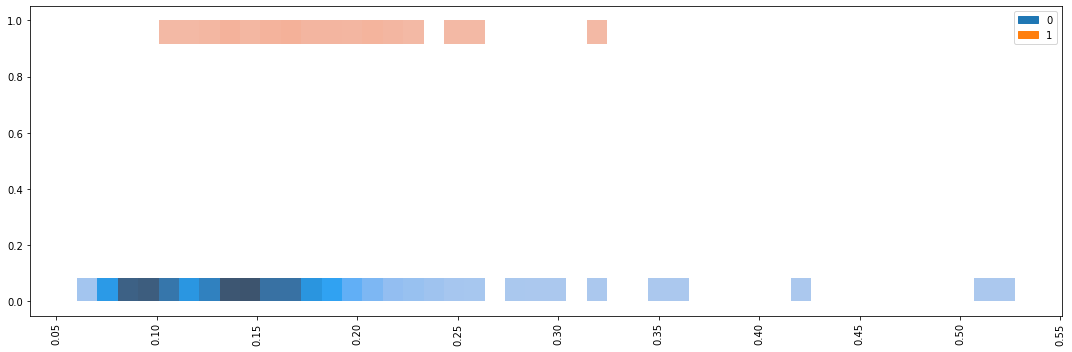

In [74]:
fig=plt.figure(figsize=(15,5))
fig.add_subplot(111)
plt.xticks(np.linspace(0,1,21,endpoint=True),rotation=90)
sns.histplot(x=X_valid_loss,y=y_valid.squeeze(),hue=y_valid)
plt.tight_layout()
plt.show()

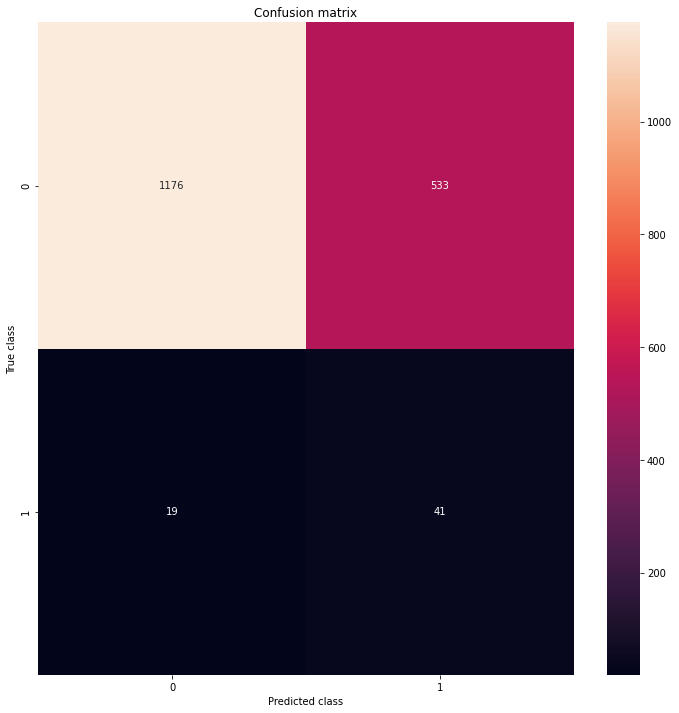

true negative rate is 0.6881217086015213
true positive rate is 0.6833333333333333


In [77]:
threshold = 0.155
Y_predict = np.where(np.array(X_valid_loss)>=threshold, 1, 0)
cm = confusion_matrix(y_valid, Y_predict)
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TP = cm[1][1]

# conf_matrix
conf_matrix = confusion_matrix(y_valid, Y_predict)
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
# print out the true positive and negative rate
print('true negative rate is ' + str(TN/(FP+TN)))
print('true positive rate is ' + str(TP/(TP+FN)))


## trained autoencoder prediction
Use the trained autoencoder to predict the test set and define the corresponding losses. Create a histogram of the test set claims, clearly marking fraudulent and non- fraudulent claims.


We can use our model to predict own dataset and examine sample wise error. Then we choose a threshold to determine which sample should be categorized into fraudulence. If error of a sample is larger than this threshold, then it should be deemed as fraudulence. Since it’s vital for insurance firms to discern positive samples correctly, we should choose a threshold with high true positive rate. We can see that autoencoder can reach AUC level of approximately 0.75, which means that it performs better than just tuning hyperparameters on original dataset, but its accuracy is not better than smote and down-sampling.

In [78]:
X_test_pred = model.predict(X_test)
X_test_loss = tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.NONE)(
    X_test, X_test_pred).numpy()
roc_score=roc_auc_score(y_test,X_test_loss)
roc_score

0.7244828683568474

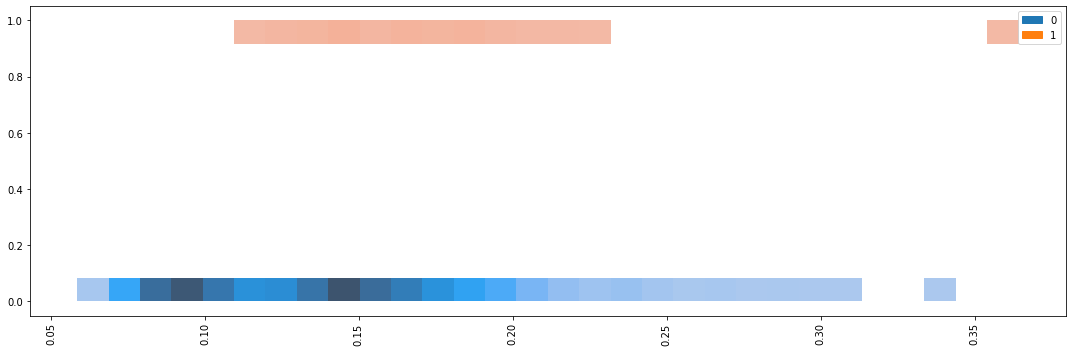

In [79]:
fig=plt.figure(figsize=(15,5))
fig.add_subplot(111)
plt.xticks(np.linspace(0,1,21,endpoint=True),rotation=90)
sns.histplot(x=X_test_loss,y=y_test.squeeze(),hue=y_test)
plt.tight_layout()
plt.show()

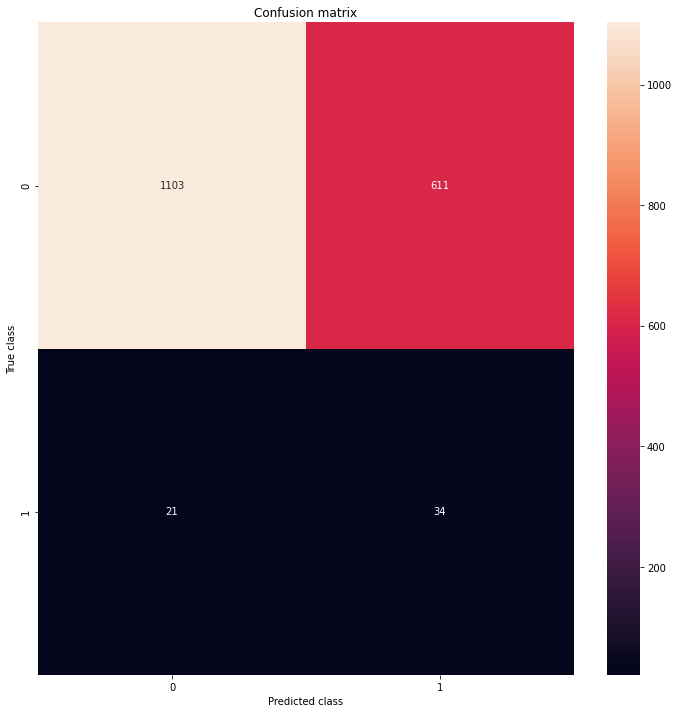

true negative rate is 0.6435239206534422
true positive rate is 0.6181818181818182


In [82]:
threshold = 0.15
Y_predict = np.where(np.array(X_test_loss)>=threshold, 1, 0)
cm = confusion_matrix(y_test, Y_predict)
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TP = cm[1][1]

# conf_matrix
conf_matrix = confusion_matrix(y_test, Y_predict)
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
# print out the true positive and negative rate
print('true negative rate is ' + str(TN/(FP+TN)))
print('true positive rate is ' + str(TP/(TP+FN)))


### why this might be problematic when the neural network prediction leads to a fraud investigation by the insurance company. What alternatives can the envision that make use of the techniques we have applied and allow for more interpretability and transparency


What’s the problem of using a neural network to a fraud :
1. Variable cannot be explained: because the neural network has many layers, and the layers are complicated. Compared with other regression methods, these variables cannot be explained, nor can they remind insurance companies which parts to focus on preventing in the early stage, and cannot solve the problem of fraud fundamentally or traceably.
2. Long operation time: When adding a new dataset, the model needs to be retrained. At present, the variables and datasets of the model are not too large and complex, but if there are many variables and datasets, compared with other regression models, it will take a lot of computing power and time to train new models.
3. Ensure that the TPR is high enough: In order to ensure that the insurance company will not be fraudulent, it will try to increase the True Positive Rate. This may cause the review before allowing insurance to be too strict, resulting in the sacrifice of reasonable claims and legal risks.
4. The model is becoming more and more difficult to learn: If the fraudster collects the claim data and his/her tech ability is good enough, he may be able to imitate deep learning and apply it to fraud to avoid it, or the model may change due to the change of features over time. The accuracy is getting lower and lower and would be also hard for model learning.
5. The problem of false negatives: Now the investigation results are actually not mature enough, and many frauds have not been completely eliminated or detected, so many cases of actual frauds have not been detected, which is the so-called fake negative. Therefore, the proportion of the dataset causing fraud in the data is very small. It may cause the features to be not obvious enough and the accuracy of the model to be poor, and the TPR to be not high enough, so if you want to achieve a very low fake negative rate, you will need to sacrifice a lot of revenue, which is not the most optimal solution.

Alternatives (more interpretability and transparency):
The following methods can directly explain the features that the model focuses on, and there are many improvements in interpretability and transparency:
1. Linear Regression: The advantage is that the model is intuitive and does not need to be trained first. The most important thing is that the computing power and time do not need too much, and the Variable can be explained. But the disadvantage is that we cannot do binary output (or categories output)
3. Logistics Regression: It can do binary or categorical (if having different thresholds) output, which makes up for the shortcomings of Linear Regression. We can observe the Logistic Regression in question 10 to understand the difference with the neural network. But the point is that many Features will not be detected or sacrifice some important information after preprocessing.
4. Decision Tree and Random Forest: The model accuracy may be more accurate than that of Logistics Regression or Linear Regression, and gini desreasing and accuracy desreasing can be used to distinguish Variables Importances, and the interpretability is also quite high.

Techniques learned in other courses that can be applied to the above methods:
1. NLP: Sentiment analysis can be used to analyze positive and negative sentiment, or it can be classified as new features by word group classification. Please note that we dropped the InsurerNotes’ columns in the previous data preprocessing, but if NLP can be used, it will be a good application
2. PCA: It can prevent too many dimensions from overfitting, but the disadvantage is the same as the neural network: once PCA is used, it may not be able to fully explain the importance of Variables


### Use the synthetically extended dataset and train a simple model, such as logistic regression that allows us to interpret why fraud is suspected. 


Step1: Train logistic model with synthesized datas:\
- obtain probabilities
- setting to find the threshold with the Validation data

In [238]:
# X_train_2, Y_train_2
logm_train = LogisticRegression(max_iter=2000).fit(X_train_2,Y_train_2.values.ravel()) 

print("Intercept = ",logm_train.intercept_)
print("Model coefficients = ", logm_train.coef_)
print("R^2 =",logm_train.score(X_train_2, Y_train_2))

Intercept =  [4.8024538]
Model coefficients =  [[-1.25969639 -0.56745655  0.04214235  0.60272525 -1.92929828  0.35050888
   0.13826874 -0.52211596 -0.01076678  0.58544635  0.30669292 -1.09953253
  -0.20280619 -1.28268449 -2.58971282  2.27579558 -1.42529333 -2.22207692
  -0.30788293 -1.49547119 -0.88303988  0.21586093 -1.42322633 -0.78388391
  -0.66873988 -0.93757736 -2.48158644 -1.51824462 -1.10756481 -0.21515606
  -3.83165172 -2.75150412 -4.48943516 -4.15594061 -4.02154193 -3.24334537
  -2.99047783 -3.84354181 -4.73751202 -2.92544606 -2.99103901 -3.47911408
  -2.12786822 -3.15872113 -1.35431092 -3.21878987 -0.36090975 -1.22044286
  -0.85756925  0.         -0.985522   -1.38868078 -2.80400073 -3.10988015
  -0.41134141 -0.54484253 -1.65194769 -0.93562013 -2.62008927 -3.73143969
  -1.02187687]]
R^2 = 0.9297989031078611


Step2: Use validation set to pick right threshold

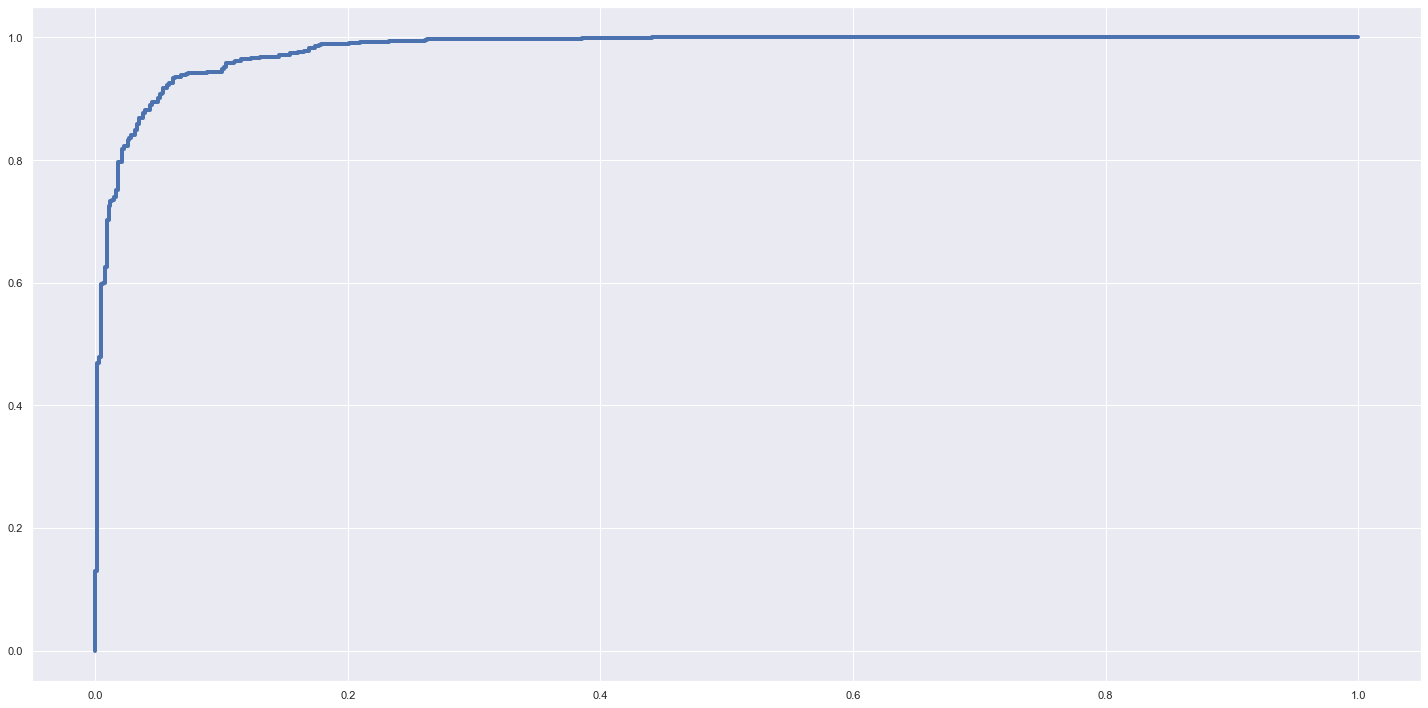

0.9815748331255201

In [239]:
# fit the validation data to the trian model
Y_probs =logm_train.predict_proba(X_valid_2)[:,1]

# get the fpr tpr score
fpr, tpr, thresholds = metrics.roc_curve(Y_valid_2,Y_probs)

plt.plot(fpr, tpr, linewidth=4)
plt.show()

#check the ROC score
roc_auc_score(Y_valid_2,Y_probs)

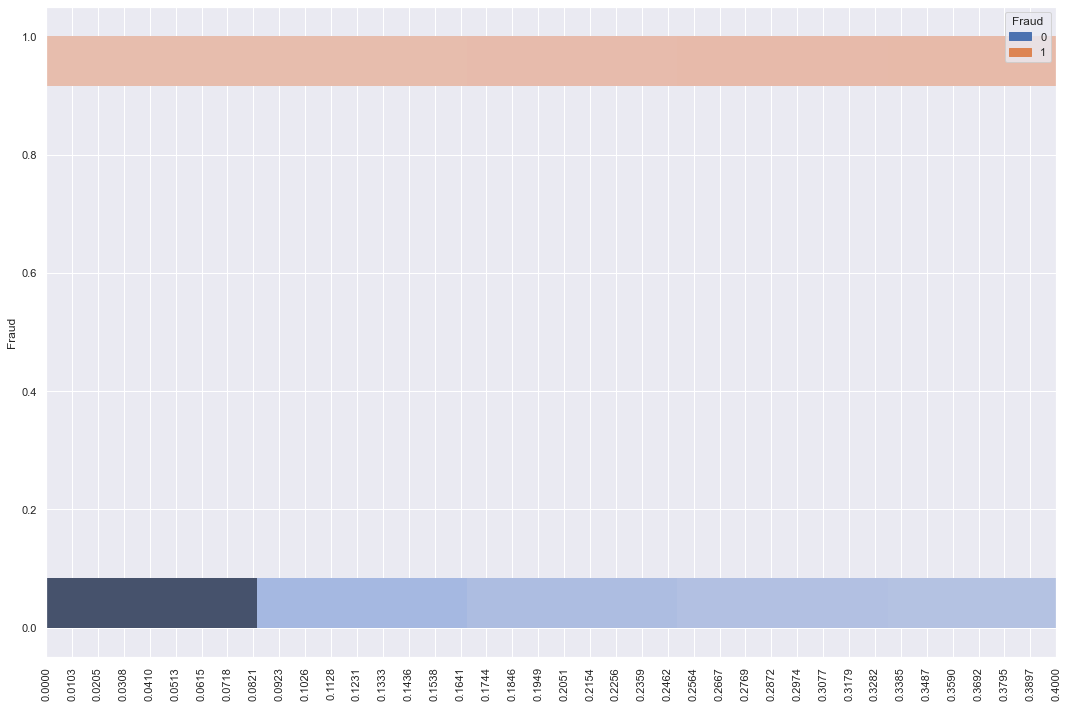

In [240]:
fig=plt.figure(figsize=(15,10))
fig.add_subplot(111)
plt.xticks(np.linspace(0,0.4,40,endpoint=True),rotation=90)
sns.histplot(x=Y_probs,y=Y_valid_2.squeeze(),hue=Y_valid_2)
plt.tight_layout()
plt.xlim([0, 0.4])
plt.show()

In [241]:
# waiting for threshold
# Select threshold based on enhanced dataset
chosen_threshold = np.min(thresholds[thresholds > 0.0821])
threshold_idx = np.where(thresholds == chosen_threshold)[0][0]

print("At threshold  " + str(thresholds[threshold_idx]))
print("the false positive rate is " + str(fpr[threshold_idx]))
print("and the true positive rate is " + str(tpr[threshold_idx]))

At threshold  0.13303239748276777
the false positive rate is 0.2623688155922039
and the true positive rate is 0.9971469329529244


In [242]:
# checking again
Y_pred = np.where(Y_probs > chosen_threshold, 1, 0)
Y_pred

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_valid_2,Y_pred)
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TP = cm[1][1]
1-TN/(FP+TN), TP/(TP+FN)

(0.26236881559220393, 0.9957203994293866)

Step3: Retraining the final model with training+validation 

In [243]:
train_val_X = pd.concat([X_train_2, X_valid_2])
train_val_Y = pd.concat([Y_train_2, Y_valid_2])

logm = LogisticRegression(max_iter=2000).fit(train_val_X, train_val_Y.values.ravel())

print("Intercept = ",logm.intercept_)
print("Model coefficients = ", logm.coef_)
print("R^2 =",logm.score(train_val_X, train_val_Y))

Intercept =  [5.08583357]
Model coefficients =  [[-1.36180116 -0.58951384  0.04583251  0.52201636 -2.03354078  0.30315737
   0.11327254 -0.53574202 -0.0229145   0.54629301  0.28707785 -1.0625065
  -0.17749854 -0.95169792 -2.62334893  2.44586072 -1.39359696 -2.01888097
  -0.26454933 -1.59951577 -0.96655727  0.22693668 -1.504596   -0.70805221
  -0.63631746 -0.97827643 -2.72978096 -1.72714231 -1.06808336 -0.18188283
  -4.21557153 -2.92336944 -4.83172571 -4.28643526 -4.52003637 -3.56912247
  -3.12071063 -4.22518158 -4.98174195 -3.19698361 -3.19940071 -3.88037618
  -2.54807626 -3.44653049 -1.64585203 -3.50261121 -0.49072845 -1.19430739
  -0.57043846  0.         -1.21815947 -1.51273563 -2.73033135 -3.69790326
  -0.51149329 -0.90759359 -1.69788893 -0.74587678 -2.75001308 -4.02504152
  -1.11380042]]
R^2 = 0.9305352442234571


 Step4: Test the accuracy of training + validation logistic model on the testing set 

In [280]:
# test dataset to check accuracy_score
Y_probs_test =logm.predict_proba(X_test)[:,1]
Y_pred_test = np.where(Y_probs_test > 0.0821, 1, 0)
cm = confusion_matrix(y_test,Y_pred_test)

TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TP = cm[1][1]

cm

array([[1214,  500],
       [   6,   49]])

In [281]:
TN/(FP+TN), TP/(TP+FN)

(0.7082847141190198, 0.8909090909090909)

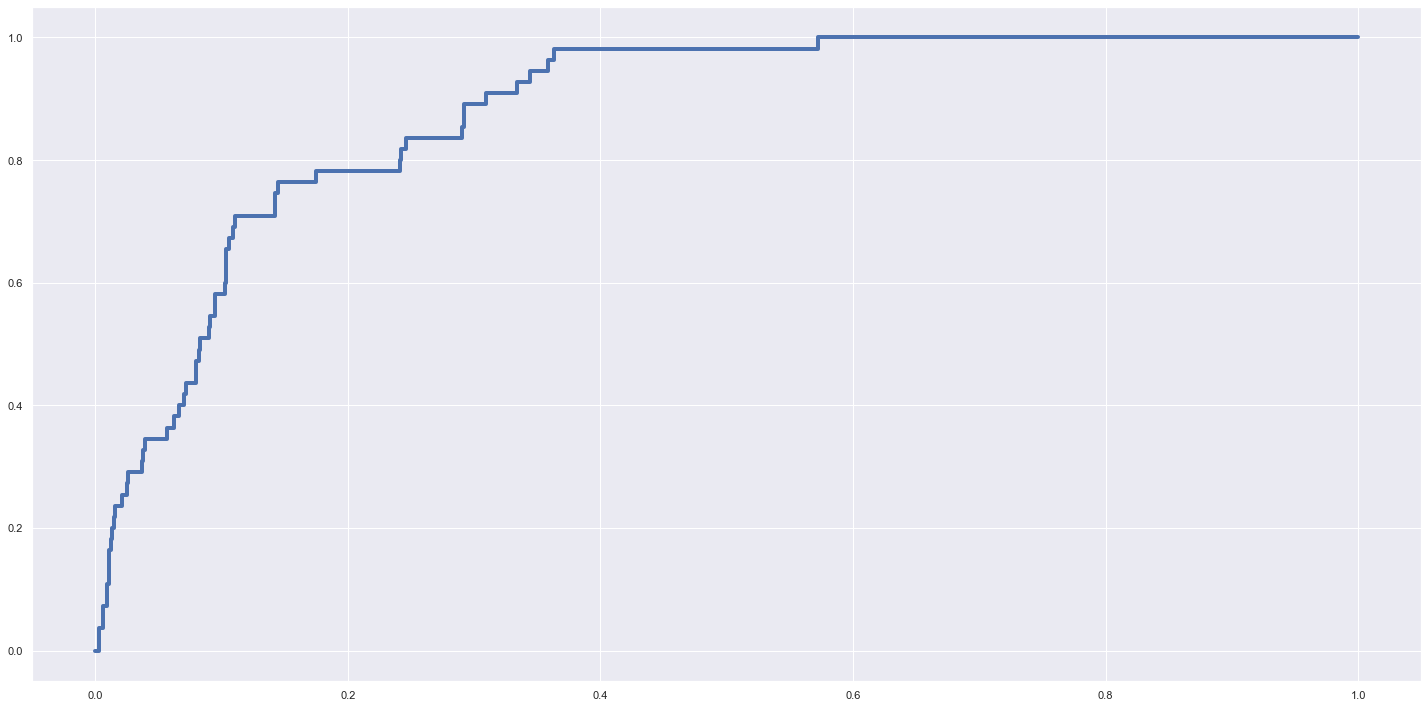

0.8806937519889678

In [247]:
# get the fpr tpr score
fpr, tpr, thresholds = metrics.roc_curve(y_test,Y_probs_test)

plt.plot(fpr, tpr, linewidth=4)
plt.show()

#check the ROC score
roc_auc_score(y_test,Y_probs_test)

In [61]:
metrics.accuracy_score(y_test,Y_pred_test)

0.9129451667608819

##### Keep track of the accuracy and AUC on a test set made from original data only.

Above table summarizes the Accuracy and AUC scores of individual models we built including two neural network models from original_turning_model and smote_turning_model, autoencoder classifier and logistic regression. However, accuracy score is not applicable for autoencoder classifier, hence, we will make comparison of models based on AUC scores obtained. 


#####   Accuracy & AUC Scores Comparison: 

#####  1. original_turning_model  vs  logistic_regression_model 

Neural network in original_turning_model has highest accuracy and AUC among all models but this does not mean that the model has actually outperformed logistic regression due to accuracy paradox. This is due to the neural network in original_turning_model is built on original imbalanced data whereby non-fraud falls under the majority class so the prediction of model is bias towards the non-fraud class of the dataset. The model will tends to learn well on non-fraud class and predict non-fraud class to achieve high accuracy score. 

#####  2. smote_turning_model  vs  logistic_regression_model 

Neural network in smote_turning_model has slightly underperformed as expected when compared to the first neural network built in original_turning_model. This model is built after adjusting for imbalanced classes and it has proven to be outperform the logistic regression with higher accuracy and AUC score. Neural network provides more flexbility as the network size can be restricted by decreasing the number of variables and hidden neurons. Network can also be pruned after training. It is a nonlinear generalizations of logistic regression, so neural network is more powerful but more computationally expensive when compared to logistic regression that is much simple model.

#####  3. autoencoding_turning_model  vs  Llogistic_regression_model

The approach for autencoder classifier is quite different from all other models that we have built, it acts as an extreme rare-event classfier for anomaly detection directly based on original imbalanced data. We observed an improvement in AUC score when compared to logistic regression. Autoencoder performs feature extraction and captures the efficient coding of the input data and projects it into lower dimension. For input data having a lot of input features as in our case of 61 features, it’s proven that model performance is better when we choose to project the data into lower dimensions and use the features for supervised learning task like insurance claim fraud detecton.


##### Does the model allow to answer a customer who asks, "why am I being investigated"?


Yes. It gives true postive rate of 0.996 and false positive rate of 0.257. However, the false positive rate is not very low that means authentic insurance claims could be potentially flagged out and misclassified as fraud claims. This creates unhappy customers who may leave and never return due to they are innocent after investigations. This creates a negative reputation. In general, although logistic regression is not the best model among all others machine learning models demonstrated here but it provides high interpretability of model parameters and has less complex model structure. In this case, it provides reasonable accuracy score of 73.48%, indicating a good model. It is more suitable for smaller and less complex dataset with lesser features.  


In [248]:
table = PrettyTable(["Model", "Accuracy Score", "AUC Score"])
table.add_row(["Neural Network (Question 3)",0.9899340271949768, 0.8869879576340862])
table.add_row(["Neural Network (Question 5)",0.96112459897995, 0.8341454272863569])
table.add_row(["Autoencoder", "NA", 0.7244828683568474])
table.add_row(["Logistic Regression",0.9129451667608819,0.8806937519889678])
print (table) 

+-----------------------------+--------------------+--------------------+
|            Model            |   Accuracy Score   |     AUC Score      |
+-----------------------------+--------------------+--------------------+
| Neural Network (Question 3) | 0.9899340271949768 | 0.8869879576340862 |
| Neural Network (Question 5) |  0.96112459897995  | 0.8341454272863569 |
|         Autoencoder         |         NA         | 0.7244828683568474 |
|     Logistic Regression     | 0.9129451667608819 | 0.8806937519889678 |
+-----------------------------+--------------------+--------------------+
